In [1]:
# --- 1.0 IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1.1 LOAD EXCEL FILE ---
file_path = "data indices.xlsx"  # Ensure this file is in the same directory as your notebook
excel_file = pd.ExcelFile(file_path)

# --- 1.2 EXTRACT 10 INDEX RETURNS AND PERFORMANCE FROM 'main ptfs' ---
return_columns_10 = [
    'SPXT return', 'RTY return', 'MXWOU return', 'LUATTRUU return', 'LUACTRUU return',
    'LF98TRUU return', 'SPGSCITR return', 'ENGL return', 'SPLPEQTR return', 'MXWD0INHF return'
]
performance_columns_10 = [col.replace("return", "perf") for col in return_columns_10]

ptf_data_df = excel_file.parse('main ptfs')
ptf_data_df['Date'] = pd.to_datetime(ptf_data_df['Date'])
ptf_data_df.set_index('Date', inplace=True)
ptf_data_df.sort_index(inplace=True)

# --- 1.3 CLEANED RETURNS & PERFORMANCE DATAFRAMES ---
ptf_returns = ptf_data_df[return_columns_10].astype(float)
ptf_performance = ptf_data_df[performance_columns_10].astype(float)
ptf_performance.columns = [col.replace(" perf", "") for col in ptf_performance.columns]


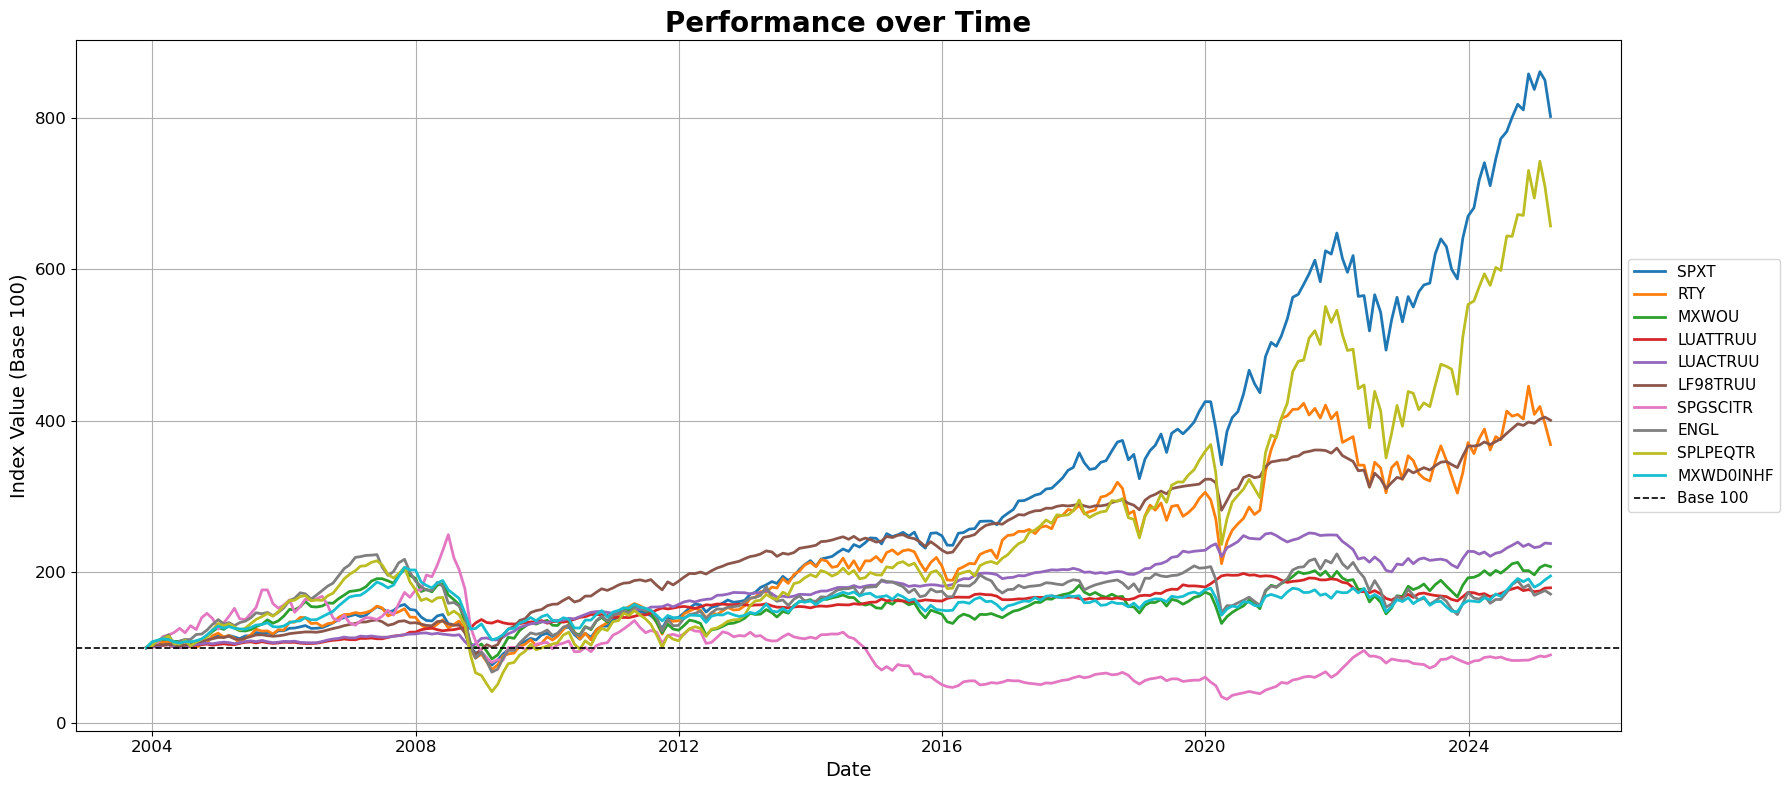

In [6]:
# --- CLEANER PLOT with BASELINE & CUSTOM LEGEND ---

plt.figure(figsize=(18, 8))

# Plot each column manually to customize legend
for column in ptf_performance.columns:
    plt.plot(ptf_performance.index, ptf_performance[column], label=column, linewidth=2)

# Add dotted black baseline at 100
plt.axhline(y=100, color='black', linestyle='--', linewidth=1.2, label='Base 100')

# Titles and labels
plt.title("Performance over Time", fontsize=20, weight='bold')
plt.ylabel("Index Value (Base 100)", fontsize=14)
plt.xlabel("Date", fontsize=14)

# Legend outside plot
plt.legend(fontsize=11, loc='center left', bbox_to_anchor=(1.0, 0.5))

# Clean formatting
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# --- Rename returns to match performance for merge ---
renamed_returns = ptf_returns.copy()
renamed_returns.columns = [col.replace(" return", "") for col in renamed_returns.columns]

# --- Recompute all statistics using aligned names ---
mean_return_10 = renamed_returns.mean()
annual_vol_10 = renamed_returns.std() * np.sqrt(12)

# Drawdown from base 100 performance (already correctly named)
rolling_max_10 = ptf_performance.cummax()
drawdown_10 = ptf_performance / rolling_max_10 - 1
max_drawdown_10 = drawdown_10.min()

# --- Combine stats ---
summary_stats_10 = pd.DataFrame({
    'Mean Monthly Return': mean_return_10,
    'Annualized Volatility': annual_vol_10,
    'Max Drawdown': max_drawdown_10
}).sort_values(by='Annualized Volatility', ascending=False)

# --- Display ---
display(summary_stats_10)


Mean Monthly Return  Annualized Volatility  Max Drawdown
SPLPEQTR              0.009935               0.244036     -0.804441
SPGSCITR              0.001921               0.226137     -0.872176
RTY                   0.006881               0.198756     -0.540802
ENGL                  0.003776               0.189350     -0.695939
MXWOU                 0.004063               0.164486     -0.581565
SPXT                  0.009071               0.146877     -0.509488
MXWD0INHF             0.003400               0.127744     -0.464973
LF98TRUU              0.005804               0.088733     -0.333071
LUACTRUU              0.003562               0.063777     -0.204614
LUATTRUU              0.002362               0.045483     -0.182950

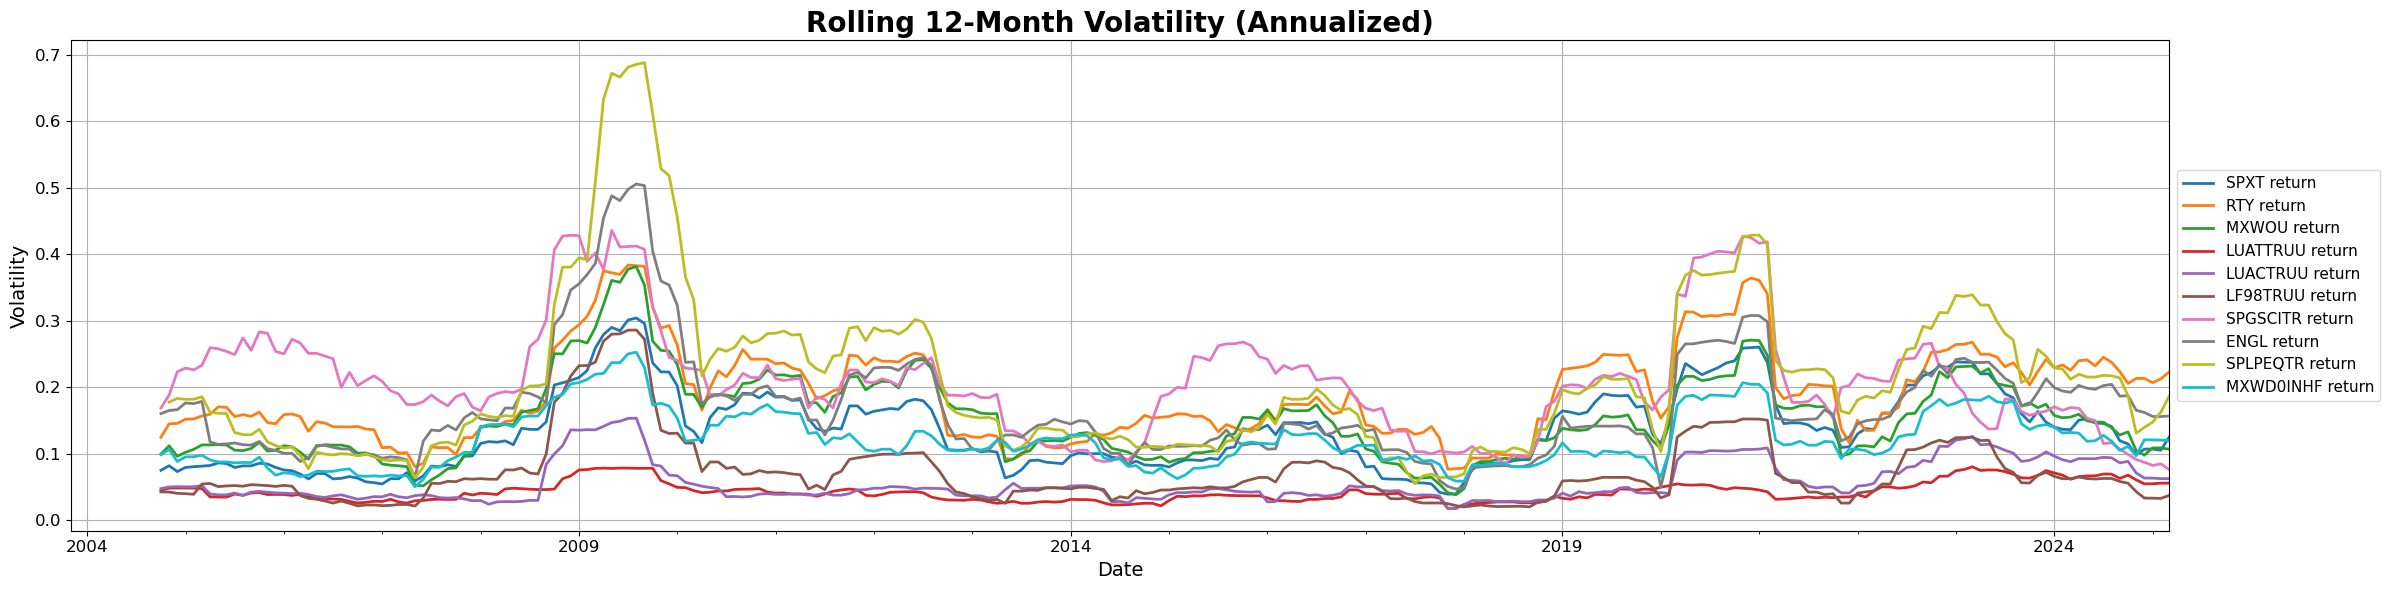

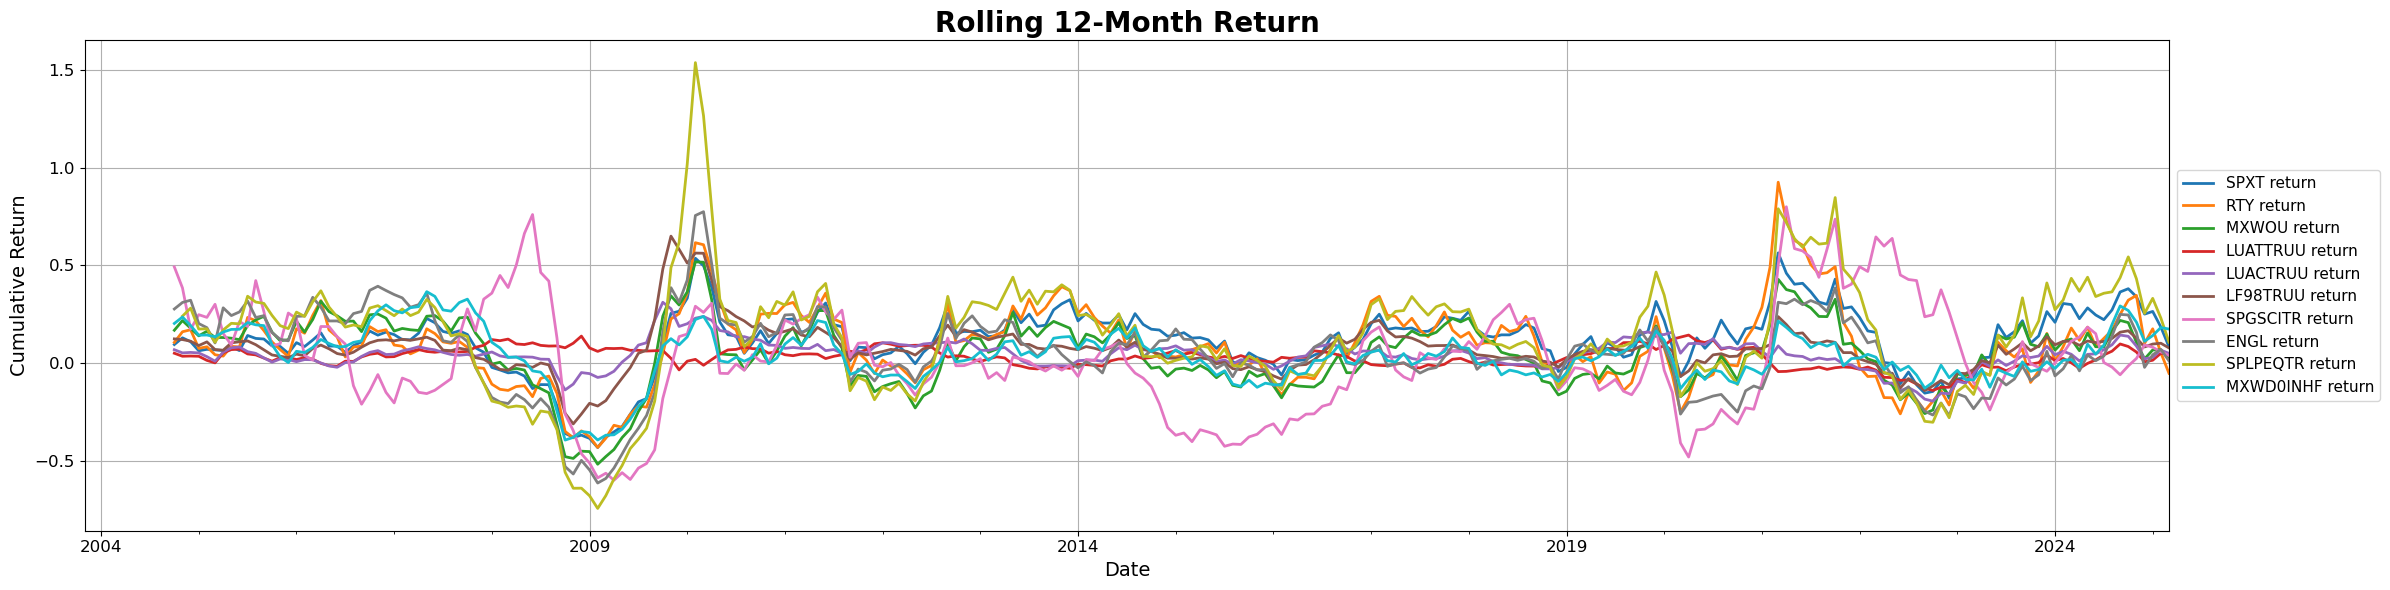

In [11]:
# --- Rolling 12-Month Volatility (Ultra-Wide) ---
rolling_vol_10 = ptf_returns.rolling(window=12).std() * np.sqrt(12)

fig, ax = plt.subplots(figsize=(24, 6))  # MUCH wider
rolling_vol_10.plot(ax=ax, linewidth=2)
ax.set_title("Rolling 12-Month Volatility (Annualized)", fontsize=20, weight='bold')
ax.set_ylabel("Volatility", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.grid(True)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=11, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

# --- Rolling 12-Month Return (Ultra-Wide) ---
rolling_return_10 = (1 + ptf_returns).rolling(window=12).apply(np.prod, raw=True) - 1

fig, ax = plt.subplots(figsize=(24, 6))  # MUCH wider
rolling_return_10.plot(ax=ax, linewidth=2)
ax.set_title("Rolling 12-Month Return", fontsize=20, weight='bold')
ax.set_ylabel("Cumulative Return", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.grid(True)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=11, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


In [19]:
ptf_data_df = excel_file.parse('main ptfs')

risk_free_series = ptf_data_df[['3M USD']].copy()
risk_free_series.index = ptf_returns.index  # align directly if they match
risk_free_series.rename(columns={'3M USD': 'Risk-Free Rate'}, inplace=True)


# Reindex to match returns and forward fill if needed
rf_aligned = risk_free_series.reindex(ptf_returns.index).fillna(method='ffill')

# --- Annualized Return & Volatility ---
annualized_return = ptf_returns.mean() * 12
annualized_volatility = ptf_returns.std() * np.sqrt(12)
# Use monthly 3M UST yields that are already annualized (in decimal format)
annualized_rf = rf_aligned['Risk-Free Rate'].mean()

# Display it
print(f"Average Annualized Risk-Free Rate: {annualized_rf:.4%}")


# --- Compute Sharpe Ratios ---
sharpe_ratios = (annualized_return - annualized_rf) / annualized_volatility

# --- Combine in DataFrame ---
sharpe_summary = pd.DataFrame({
    'Annualized Return': annualized_return,
    'Annualized Volatility': annualized_volatility,
    'Avg Risk-Free Rate': annualized_rf,
    'Sharpe Ratio': sharpe_ratios
}).sort_values(by='Sharpe Ratio', ascending=False)

# --- Display ---
display(sharpe_summary)


Average Annualized Risk-Free Rate: 1.6309%


/var/folders/8z/c993dyxd7_7192clm2cw4qyr0000gn/T/ipykernel_72946/3979562510.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_aligned = risk_free_series.reindex(ptf_returns.index).fillna(method='ffill')


Annualized Return  Annualized Volatility  \
SPXT return                0.108855               0.146877   
LF98TRUU return            0.069653               0.088733   
SPLPEQTR return            0.119215               0.244036   
LUACTRUU return            0.042742               0.063777   
RTY return                 0.082569               0.198756   
LUATTRUU return            0.028341               0.045483   
MXWOU return               0.048759               0.164486   
MXWD0INHF return           0.040795               0.127744   
ENGL return                0.045316               0.189350   
SPGSCITR return            0.023055               0.226137   

                  Avg Risk-Free Rate  Sharpe Ratio  
SPXT return                 0.016309      0.630087  
LF98TRUU return             0.016309      0.601176  
SPLPEQTR return             0.016309      0.421684  
LUACTRUU return             0.016309      0.414467  
RTY return                  0.016309      0.333375  
LUATTRUU return             0.016309      0.264525  
MXWOU return                0.016309      0.197283  
MXWD0INHF return            0.016309      0.191679  
ENGL return                 0.016309      0.153195  
SPGSCITR return             0.016309      0.029831

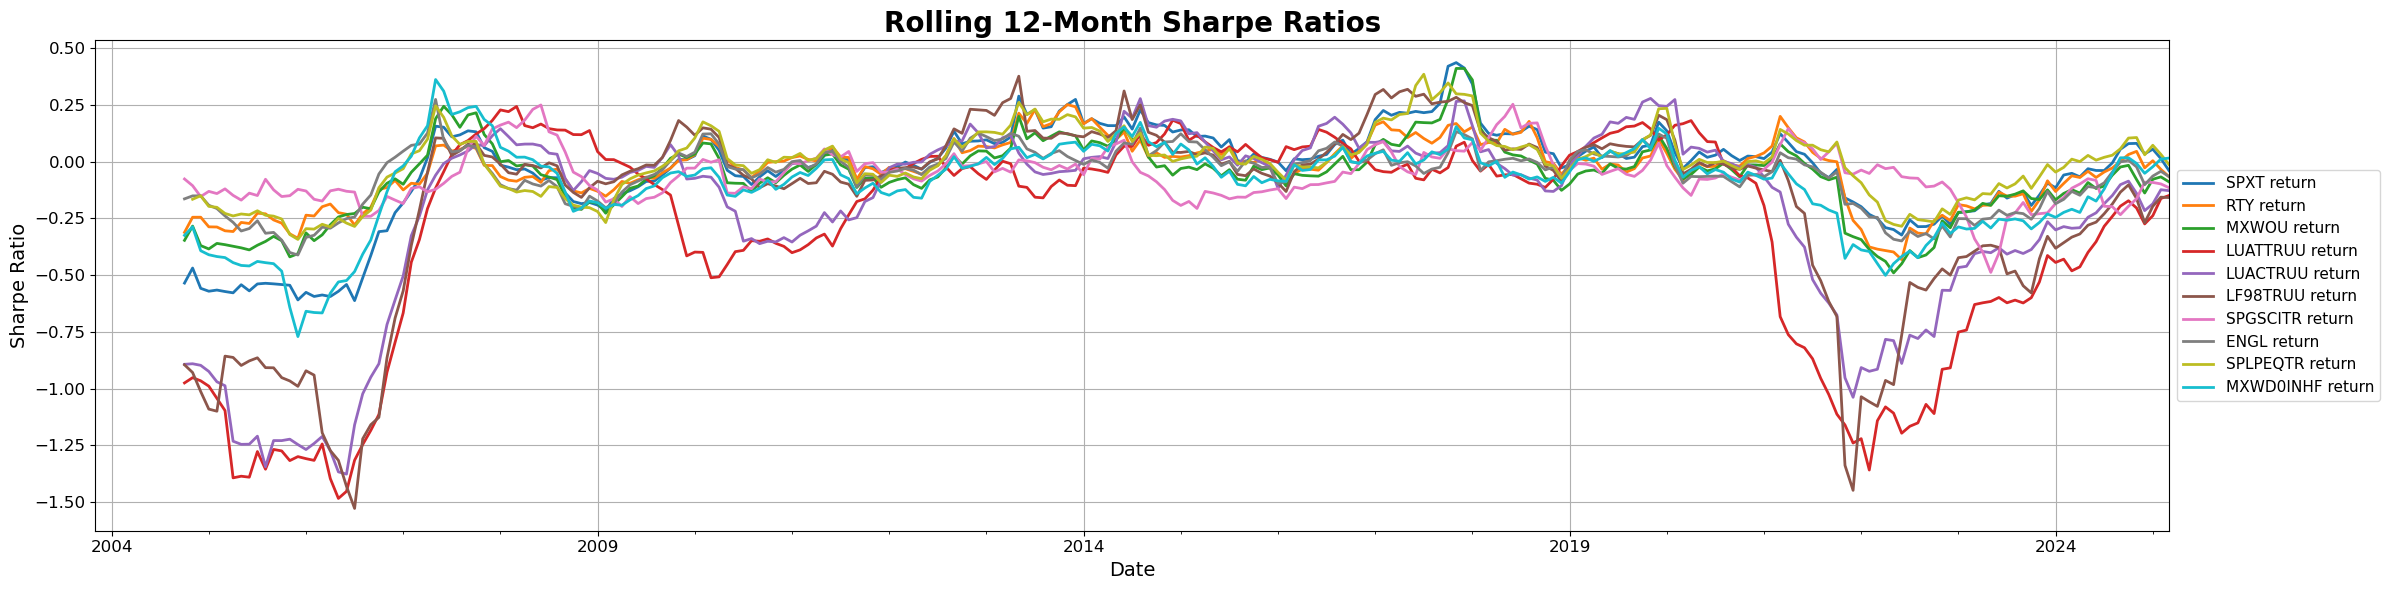

In [20]:
# --- Rolling 12-Month Sharpe Ratios ---
excess_return = ptf_returns.sub(rf_aligned['Risk-Free Rate'], axis=0)
rolling_excess = excess_return.rolling(window=12).mean()
rolling_vol = ptf_returns.rolling(window=12).std()
rolling_sharpe = rolling_excess / (rolling_vol * np.sqrt(12))

# --- Plot ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(24, 6))
rolling_sharpe.plot(ax=ax, linewidth=2)
ax.set_title("Rolling 12-Month Sharpe Ratios", fontsize=20, weight='bold')
ax.set_ylabel("Sharpe Ratio", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.grid(True)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=11, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


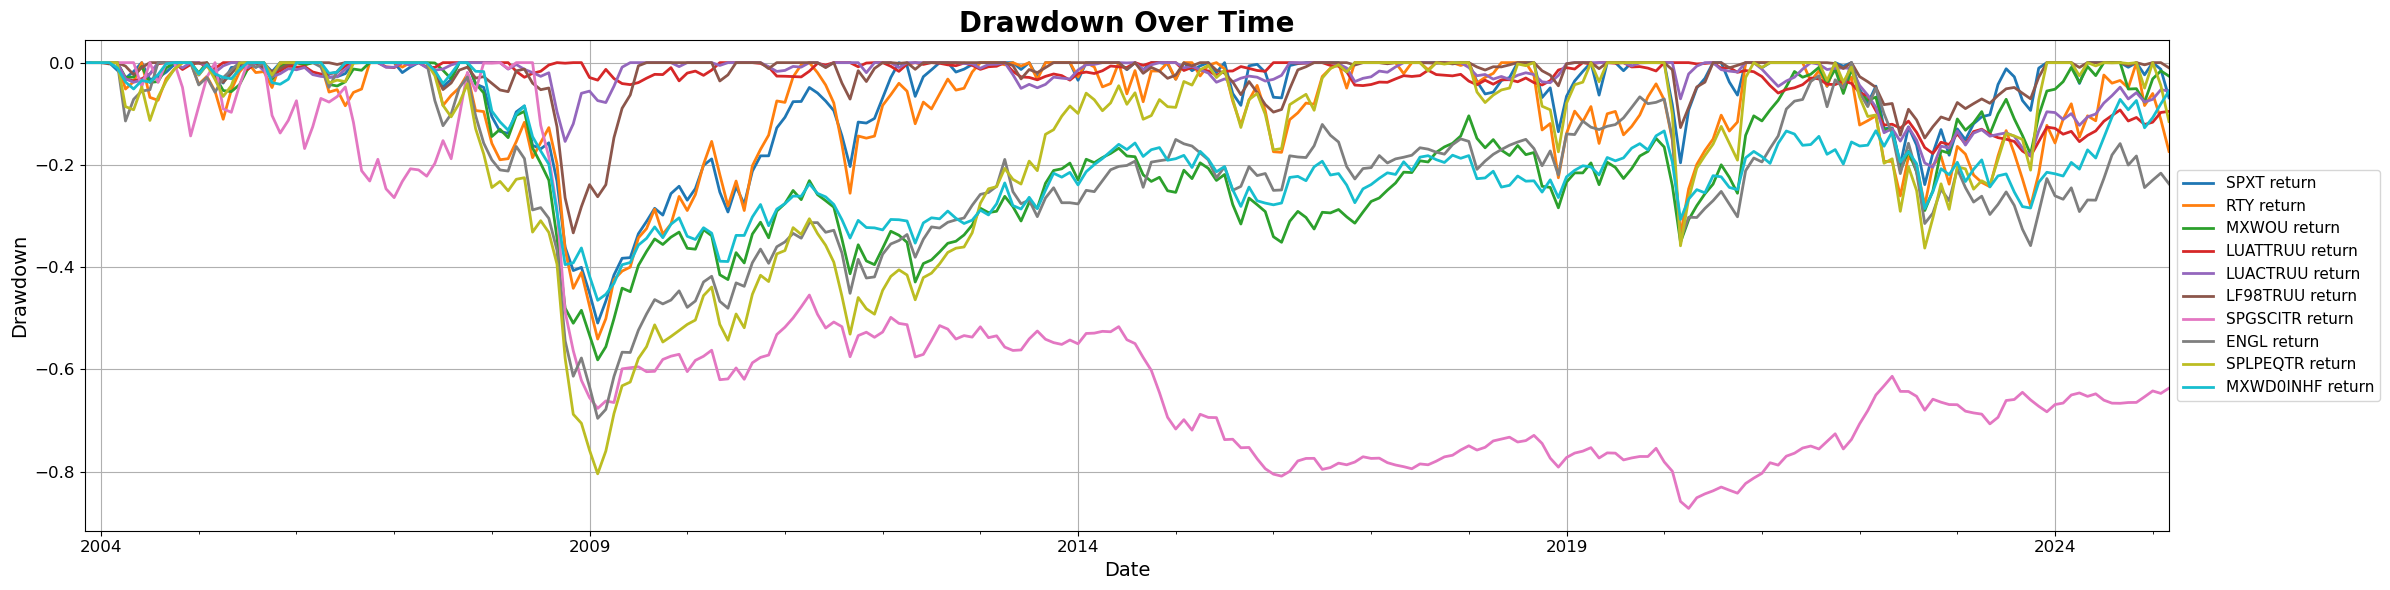

In [21]:
# --- Drawdown calculation ---
cumulative_perf = (1 + ptf_returns).cumprod()
rolling_max_perf = cumulative_perf.cummax()
drawdowns = cumulative_perf / rolling_max_perf - 1

# --- Plot ---
fig, ax = plt.subplots(figsize=(24, 6))
drawdowns.plot(ax=ax, linewidth=2)
ax.set_title("Drawdown Over Time", fontsize=20, weight='bold')
ax.set_ylabel("Drawdown", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.grid(True)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=11, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()


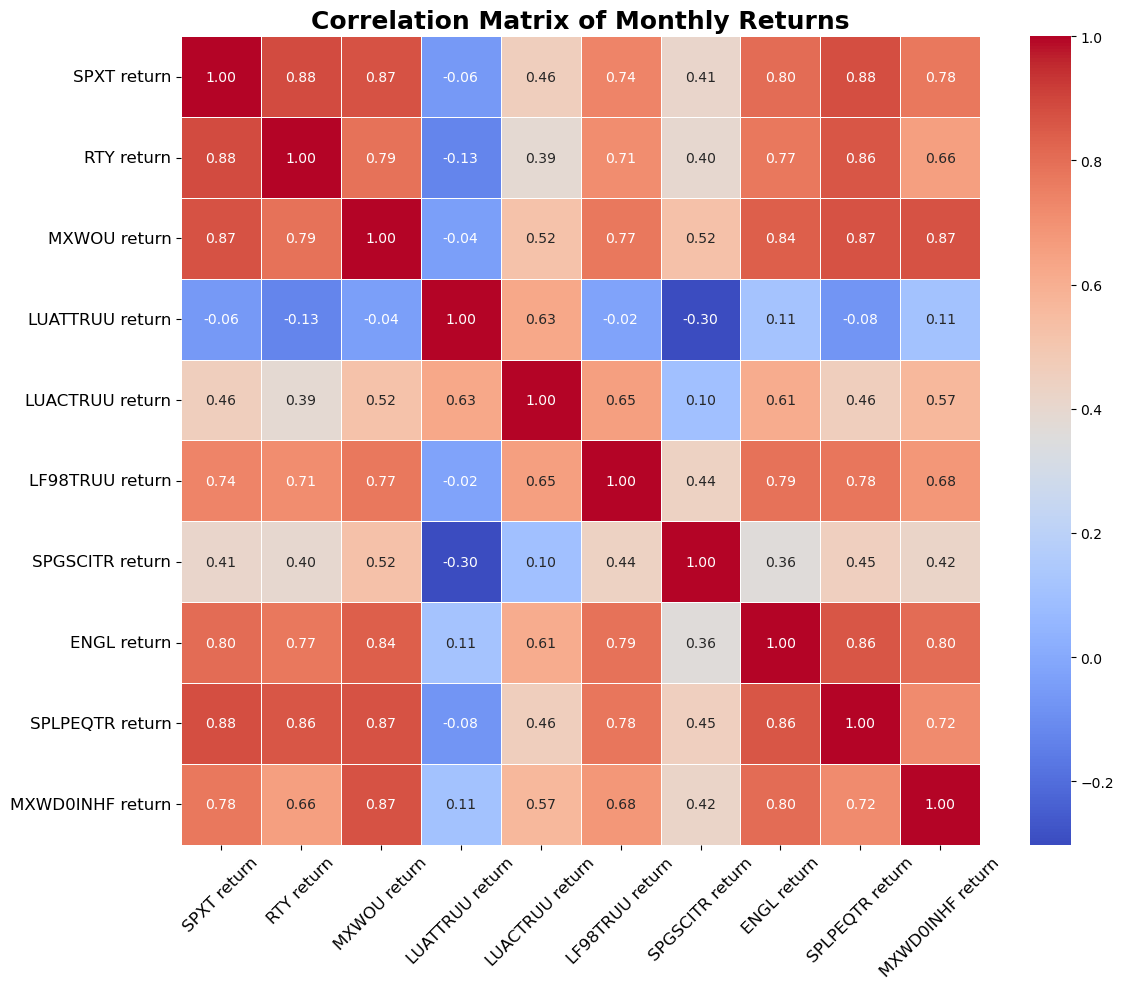

In [22]:
# --- Correlation Matrix of Monthly Returns ---
import seaborn as sns

correlation_matrix = ptf_returns.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Monthly Returns", fontsize=18, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


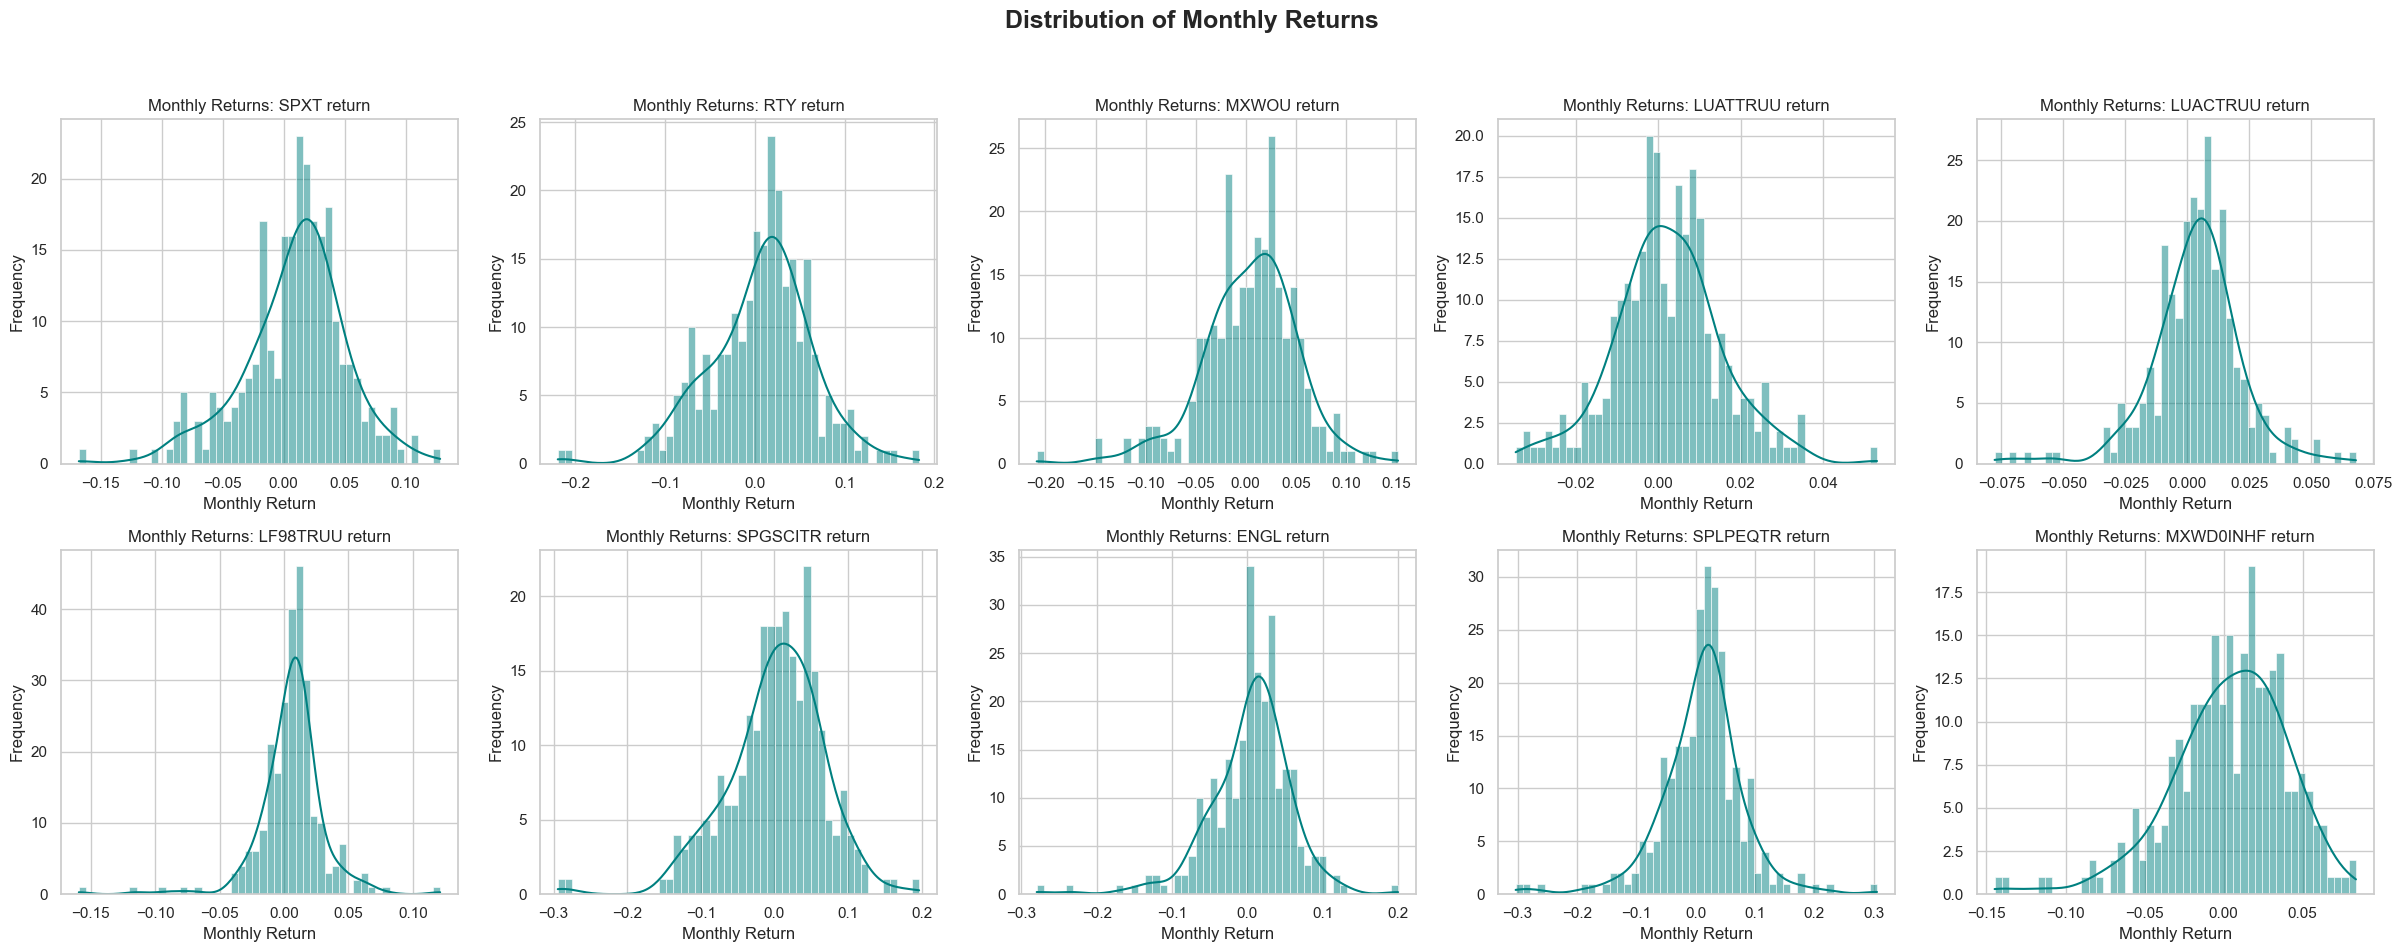

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set visual style
sns.set(style="whitegrid")

# Plot histogram + KDE for each index
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
axes = axes.flatten()

for i, column in enumerate(ptf_returns.columns):
    sns.histplot(ptf_returns[column], bins=50, kde=True, ax=axes[i], color='teal')
    axes[i].set_title(f"Monthly Returns: {column}", fontsize=12)
    axes[i].set_xlabel("Monthly Return")
    axes[i].set_ylabel("Frequency")

plt.suptitle("Distribution of Monthly Returns", fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


1. SPXT (S&P 500):
Slightly right-skewed, thin tails → mostly normal behavior

Some extreme negative returns (crises) show up as longer left tails

2. RTY (Small Cap):
Fatter tails, slight right skew → higher risk & opportunity

Volatility is visibly greater than SPXT

3. LF98TRUU (High Yield Bonds):
Very tight, peaked distribution → low volatility

Slight left skew, but still fairly normal

4. SPGSCITR (Commodities) & SPLPEQTR (Private Equity):
Very fat tails, especially left

Skewed and leptokurtic → high drawdown risk

5. MXWD0INHF (Inflation-linked bonds):
Mild left skew

Mostly safe-haven type profile



we want long positions only since when optimizing we get negative values, and also we put a constraint  between 5 to 30% because when optimizing we get 0 weights but we woulkd like to diversify as much as possible

In [27]:
# --- Imports ---
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from numba import njit, prange
import matplotlib.pyplot as plt

# --- Load Excel File ---
file_path = "data indices.xlsx"
excel_file = pd.ExcelFile(file_path)
ptf_data_df = excel_file.parse('main ptfs')
ptf_data_df['Date'] = pd.to_datetime(ptf_data_df['Date'])
ptf_data_df.set_index('Date', inplace=True)
ptf_data_df.sort_index(inplace=True)

# --- Extract Monthly Returns of the 10 Indices ---
return_columns_10 = [
    'SPXT return', 'RTY return', 'MXWOU return', 'LUATTRUU return', 'LUACTRUU return',
    'LF98TRUU return', 'SPGSCITR return', 'ENGL return', 'SPLPEQTR return', 'MXWD0INHF return'
]
ptf_returns = ptf_data_df[return_columns_10].astype(float)
columns = ptf_returns.columns.tolist()
returns = ptf_returns.copy()
sample_length = returns.shape[0]

# --- Stationary Bootstrapping Function ---
@njit(parallel=True)
def stationary_bootstrap_inner(data_array, sample_length, nb_of_samples, block_length_mean):
    n = data_array.shape[0]
    bootstrap_data = np.empty((nb_of_samples, sample_length), dtype=data_array.dtype)
    p = 1.0 / block_length_mean
    for sample in prange(nb_of_samples):
        bootstrap_indices = np.zeros(sample_length, dtype=np.int64)
        idx = 0
        while idx < sample_length:
            block_length = np.random.geometric(p)
            start_index = np.random.randint(0, n)
            block_indices = (np.arange(block_length) + start_index) % n
            copy_length = min(block_length, sample_length - idx)
            bootstrap_indices[idx:idx+copy_length] = block_indices[:copy_length]
            idx += copy_length
        bootstrap_data[sample, :] = data_array[bootstrap_indices]
    return bootstrap_data

def MultiStationaryBootstrap(data, columns, sample_length, nb_of_samples=1000, block_length_mean=40, dtype=np.float32):
    data_arrays = {column: data[column].values.astype(dtype) for column in columns}
    bootstrap_data = {
        column: stationary_bootstrap_inner(data_arrays[column], sample_length, nb_of_samples, block_length_mean)
        for column in columns
    }
    return bootstrap_data

# --- Generate Bootstrapped Samples ---
boot = MultiStationaryBootstrap(returns, columns, sample_length)

# --- Equal Weight Portfolio ---
equal_weight = np.repeat(1 / len(columns), len(columns))
boot_weights_equal = np.tile(equal_weight, (1000, 1))

# --- Minimum Variance Portfolio Function ---
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def min_var_portfolio(cov_matrix, bounds, constraint):
    n = cov_matrix.shape[0]
    init_guess = np.repeat(1 / n, n)
    result = minimize(
        portfolio_volatility,
        init_guess,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=[constraint]
    )
    return result.x if result.success else init_guess

# --- Set Constraints (5%–30%, Long-only, Sum = 1) ---
n_assets = len(columns)
bounds = tuple((0.05, 0.30) for _ in range(n_assets))
constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# --- Compute MinVar Portfolio for Each Bootstrap Sample ---
boot_weights_minvar = []
for i in range(1000):
    sample = np.array([boot[col][i] for col in columns]).T
    sample_df = pd.DataFrame(sample, columns=columns)
    cov_matrix = sample_df.cov().values
    w_minvar = min_var_portfolio(cov_matrix, bounds, constraint)
    boot_weights_minvar.append(w_minvar)

boot_weights_minvar = np.array(boot_weights_minvar)

# --- Convert to DataFrames ---
df_weights_equal = pd.DataFrame(boot_weights_equal, columns=columns)
df_weights_minvar = pd.DataFrame(boot_weights_minvar, columns=columns)


In [31]:
# --- Average portfolio weights from bootstrapped results ---
avg_weights_equal = df_weights_equal.mean().values
avg_weights_minvar = df_weights_minvar.mean().values

# --- Compute historical monthly returns of each portfolio ---
returns_equal = ptf_returns @ avg_weights_equal
returns_minvar = ptf_returns @ avg_weights_minvar

# --- Combine into single DataFrame ---
ptf_return_series = pd.DataFrame({
    'Equal Weight': returns_equal,
    'Min Variance': returns_minvar
})

# --- Compute Portfolio Statistics ---
summary_stats = pd.DataFrame({
    'Annualized Return': ptf_return_series.mean() * 12,
    'Annualized Volatility': ptf_return_series.std() * np.sqrt(12),
    'Sharpe Ratio (RF=0%)': ((ptf_return_series.mean() * 12) - annualized_rf) / (ptf_return_series.std() * np.sqrt(12)),
    'Max Drawdown': (ptf_return_series / ptf_return_series.cummax() - 1).min()
})

# --- Display ---
print("Portfolio Return Statistics (Equal Weight & Minimum Variance):")
display(summary_stats)


Portfolio Return Statistics (Equal Weight & Minimum Variance):


Annualized Return  Annualized Volatility  Sharpe Ratio (RF=0%)  \
Equal Weight           0.060293               0.121994              0.360541   
Min Variance           0.050123               0.076943              0.439468   

              Max Drawdown  
Equal Weight     -5.552837  
Min Variance     -5.329574

In [120]:
print(annualized_rf)

0.016309042801556418


In [38]:
from scipy.optimize import minimize

# --- Helper Functions ---
def negative_sharpe_ratio(weights, mean_returns, cov_matrix):
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -port_return / port_vol

def max_sharpe_portfolio(mean_returns, cov_matrix, bounds, constraint):
    n = len(mean_returns)
    init_guess = np.repeat(1 / n, n)
    result = minimize(
        negative_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix),
        method='SLSQP', bounds=bounds, constraints=[constraint]
    )
    return result.x if result.success else init_guess

def risk_contribution(weights, cov_matrix):
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    marginal_contrib = np.dot(cov_matrix, weights)
    risk_contrib = weights * marginal_contrib / portfolio_vol
    return risk_contrib

def erc_loss(weights, cov_matrix):
    rc = risk_contribution(weights, cov_matrix)
    return np.sum((rc - rc.mean())**2)

def erc_portfolio(cov_matrix, bounds, constraint):
    n = cov_matrix.shape[0]
    init_guess = np.repeat(1 / n, n)
    result = minimize(
        erc_loss, init_guess, args=(cov_matrix,), method='SLSQP',
        bounds=bounds, constraints=[constraint]
    )
    return result.x if result.success else init_guess

# --- Constraint Setup ---
n_assets = len(columns)
bounds = tuple((0.05, 0.30) for _ in range(n_assets))
constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# --- Bridgewater Capital Allocation Targets ---
target_weights = {
    'LUATTRUU return': 0.40,
    'LUACTRUU return': 0.10,
    'LF98TRUU return': 0.10,
    'SPXT return': 0.18,
    'RTY return': 0.05,
    'MXWOU return': 0.05,
    'SPGSCITR return': 0.07,
    'SPLPEQTR return': 0.05,
    'MXWD0INHF return': 0.05
}
target_weights = {k: v / sum(target_weights.values()) for k, v in target_weights.items()}
target_array = np.array([target_weights.get(col, 1 / n_assets) for col in columns])

# --- Objective: minimize deviation from Bridgewater targets ---
def deviation_from_target(w, target):
    return np.sum((w - target)**2)

# --- Constrained optimization for All Weather ---
init_guess = np.repeat(1 / n_assets, n_assets)
result = minimize(
    deviation_from_target,
    init_guess,
    args=(target_array,),
    method='SLSQP',
    bounds=bounds,
    constraints=[constraint]
)

optimal_bw_weights = result.x
df_weights_allweather = pd.DataFrame(np.tile(optimal_bw_weights, (1000, 1)), columns=columns)

# --- Bootstrap Max Sharpe & ERC ---
boot_weights_maxsharpe = []
boot_weights_erc = []

for i in range(1000):
    sample = np.array([boot[col][i] for col in columns]).T
    sample_df = pd.DataFrame(sample, columns=columns)
    mean_returns = sample_df.mean().values
    cov_matrix = sample_df.cov().values

    w_sharpe = max_sharpe_portfolio(mean_returns, cov_matrix, bounds, constraint)
    w_erc = erc_portfolio(cov_matrix, bounds, constraint)

    boot_weights_maxsharpe.append(w_sharpe)
    boot_weights_erc.append(w_erc)

df_weights_maxsharpe = pd.DataFrame(boot_weights_maxsharpe, columns=columns)
df_weights_erc = pd.DataFrame(boot_weights_erc, columns=columns)


Your chosen indices (e.g., SPXT, RTY, MXWOU) have high correlation, especially in equity-heavy portfolios.

Even assets like commodities or bonds are often directionally aligned over long periods, especially in a low-rate environment (like post-2009 and COVID-2020 rebound).



/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


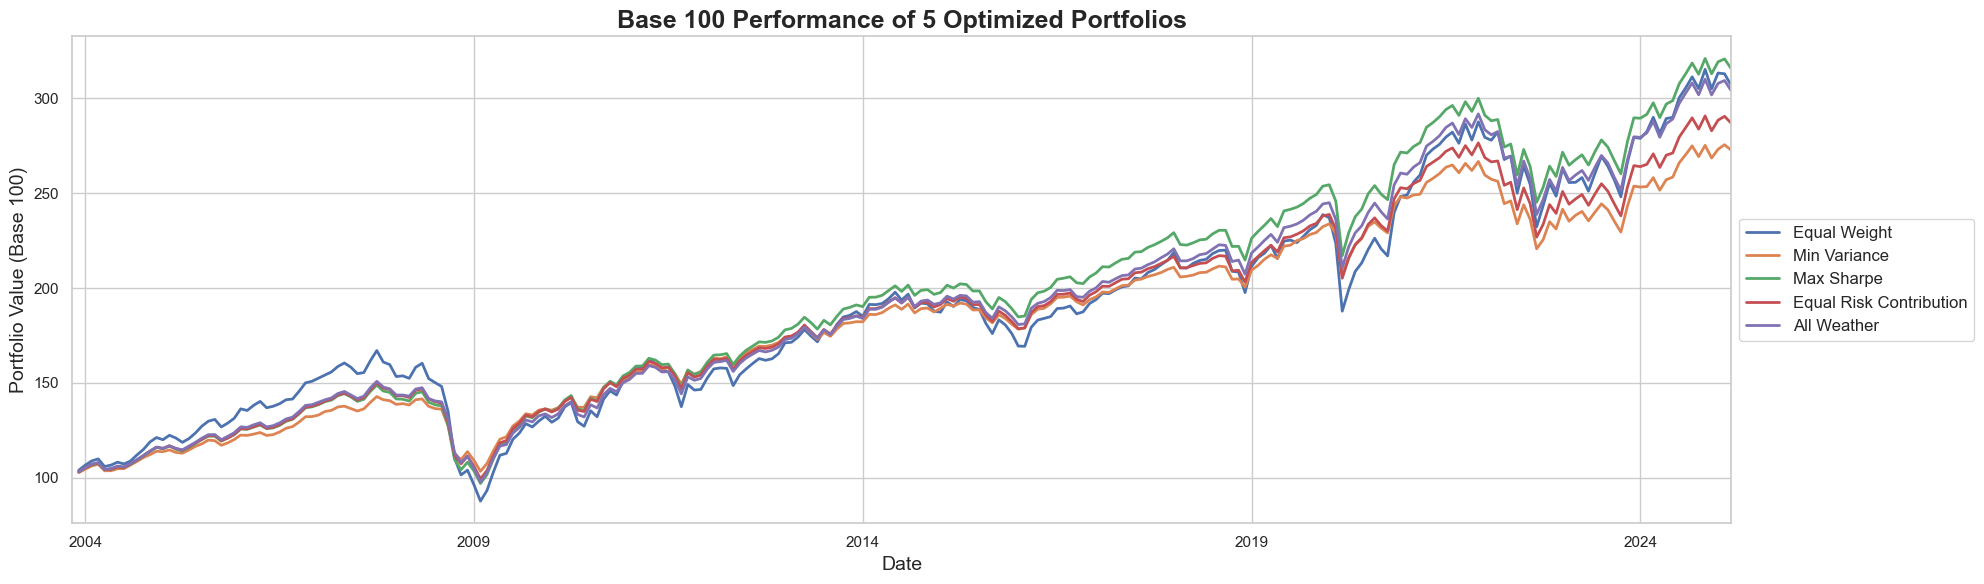

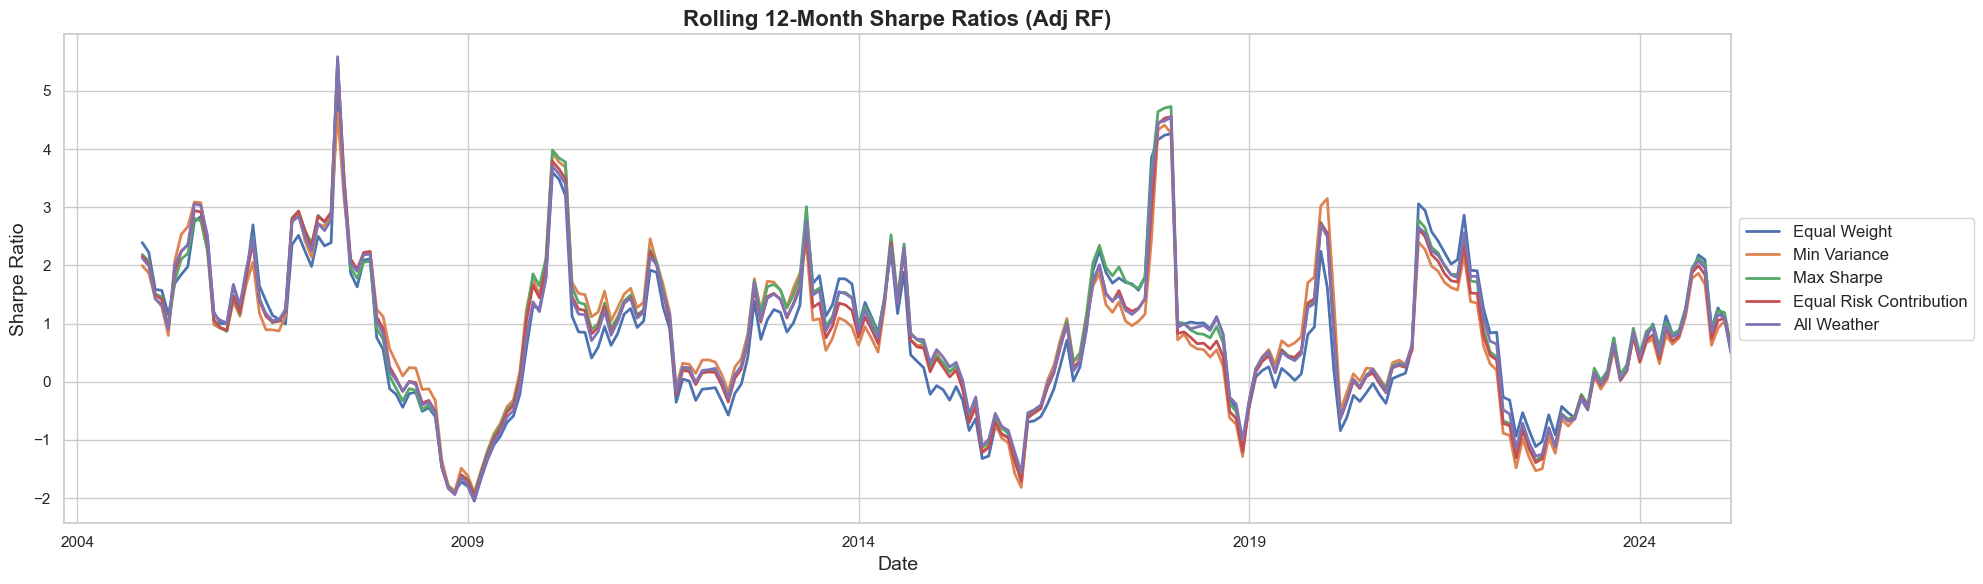

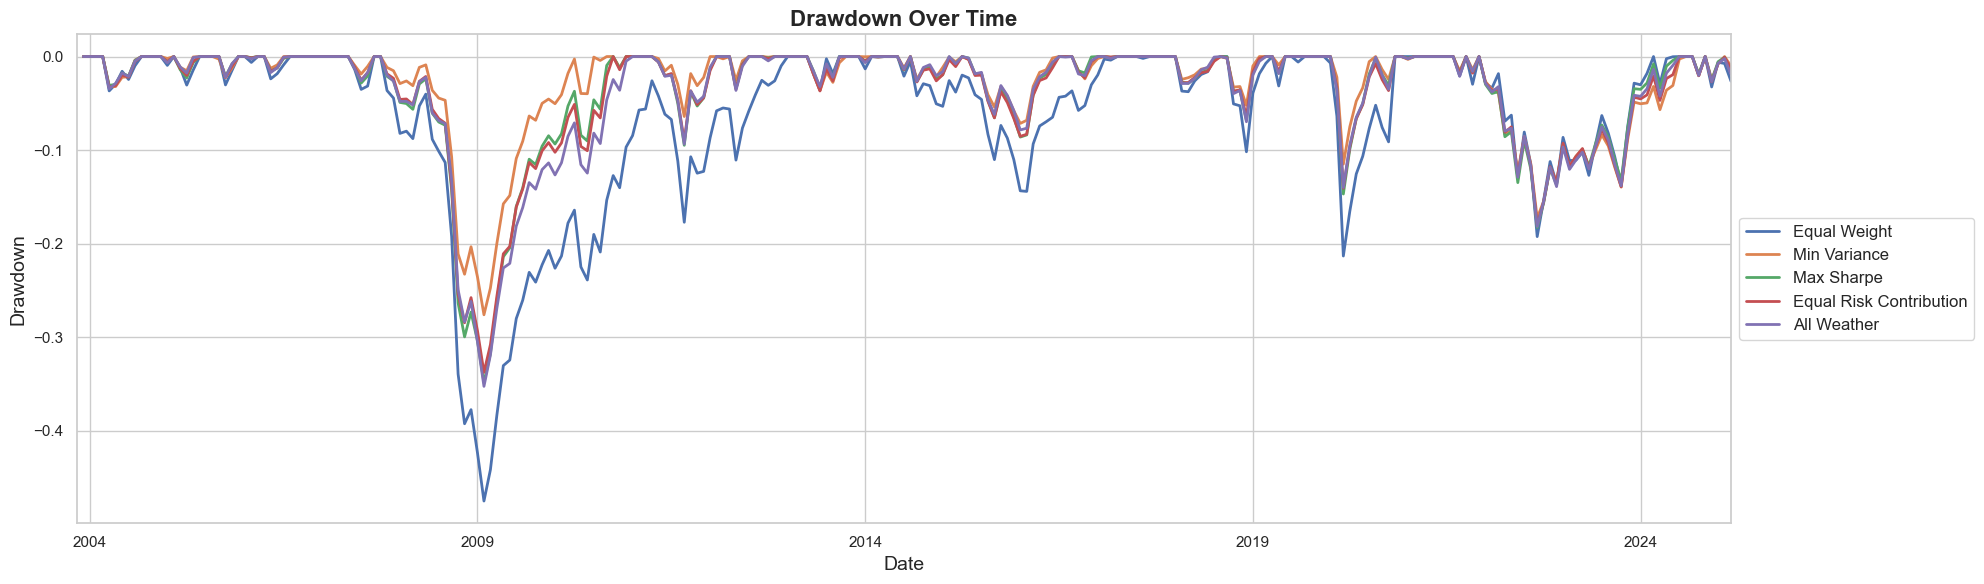

Annualized Return  Annualized Volatility  \
Equal Weight                      0.060293               0.121994   
Min Variance                      0.050123               0.076943   
Max Sharpe                        0.058337               0.092207   
Equal Risk Contribution           0.053546               0.089086   
All Weather                       0.056463               0.091095   

                         Sharpe Ratio (Adj RF)  Max Drawdown  
Equal Weight                          0.360541     -5.552837  
Min Variance                          0.439468     -5.329574  
Max Sharpe                            0.455796     -5.509069  
Equal Risk Contribution               0.417990     -5.205467  
All Weather                           0.440790     -5.220820

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================================================
# PART 1: Define Optimizers for Portfolios with Constraints (5%-30%, Long-only)
# ============================================================================
n_assets = len(columns)
bounds = tuple((0.05, 0.30) for _ in range(n_assets))
constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# --- Equal Weight Portfolio: Simple constant weight ---
equal_weight = np.repeat(1 / n_assets, n_assets)

# --- Minimum Variance Portfolio ---
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def min_var_portfolio(cov_matrix, bounds, constraint):
    init_guess = np.repeat(1 / n_assets, n_assets)
    res = minimize(portfolio_volatility, init_guess, args=(cov_matrix,), method='SLSQP',
                   bounds=bounds, constraints=[constraint])
    if not res.success:
        print("MinVar optimizer did not converge; using equal weights")
    return res.x if res.success else init_guess

# --- Maximum Sharpe Ratio Portfolio ---
def negative_sharpe_ratio(weights, mean_returns, cov_matrix):
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return - port_return / port_vol

def max_sharpe_portfolio(mean_returns, cov_matrix, bounds, constraint):
    init_guess = np.repeat(1 / n_assets, n_assets)
    res = minimize(negative_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix),
                   method='SLSQP', bounds=bounds, constraints=[constraint])
    if not res.success:
        print("Max Sharpe optimizer did not converge; using equal weights")
    return res.x if res.success else init_guess

# --- Equal Risk Contribution (ERC) Portfolio ---
def erc_loss(weights, cov_matrix):
    # Calculate portfolio variance and risk contributions in percentage terms.
    port_var = np.dot(weights.T, np.dot(cov_matrix, weights))
    port_risk = np.sqrt(port_var)
    # Marginal risk contributions:
    mrc = np.dot(cov_matrix, weights)
    # Absolute risk contributions:
    risk_contrib = weights * mrc
    # Convert to percentage contributions (summing to 1)
    risk_contrib_pct = risk_contrib / port_var
    target = 1.0 / n_assets  # equal risk share target
    return np.sum((risk_contrib_pct - target)**2)

def erc_portfolio(cov_matrix, bounds, constraint):
    init_guess = np.repeat(1 / n_assets, n_assets)
    res = minimize(erc_loss, init_guess, args=(cov_matrix,), method='SLSQP',
                   bounds=bounds, constraints=[constraint])
    if not res.success:
        print("ERC optimizer did not converge; using equal weights")
    return res.x if res.success else init_guess


# --- All Weather Portfolio (Constrained to 5%-30%)
# Target macro allocations inspired by Bridgewater (adapted to your indices)
target_weights = {
    'LUATTRUU return': 0.40,  # Long-term bonds
    'LUACTRUU return': 0.10,  # Corporate bonds
    'LF98TRUU return': 0.10,  # High yield
    'SPXT return': 0.18,      # U.S. equities
    'RTY return': 0.05,       # Small-cap
    'MXWOU return': 0.05,     # Global equities
    'SPGSCITR return': 0.07,  # Commodities
    'SPLPEQTR return': 0.05,  # Private equity proxy
    'MXWD0INHF return': 0.05  # Inflation-linked bonds, now nonzero
}
target_weights = {k: v / sum(target_weights.values()) for k, v in target_weights.items()}
# Build target array aligned with your `columns`
target_array = np.array([target_weights.get(col, 1 / n_assets) for col in columns])

def deviation_from_target(w, target):
    return np.sum((w - target)**2)

# Optimize All Weather portfolio by forcing weights close to target under constraints.
init_guess = np.repeat(1 / n_assets, n_assets)
res_allweather = minimize(deviation_from_target, init_guess, args=(target_array,),
                          method='SLSQP', bounds=bounds, constraints=[constraint])
if not res_allweather.success:
    print("All Weather optimization did not converge; using target weights")
optimal_allweather = res_allweather.x if res_allweather.success else target_array

# ============================================================================
# PART 2: Bootstrapping: For each bootstrap sample, solve for portfolios
# ============================================================================
# Assume `boot` is a dictionary: each key=asset column, value = array of shape (nb_samples, sample_length)
nb_samples = 1000  # as used earlier

boot_weights_maxsharpe = []
boot_weights_erc = []
boot_weights_minvar = []  # for consistency

for i in range(nb_samples):
    # Extract the i-th bootstrap sample and form DataFrame
    sample = np.array([boot[col][i] for col in columns]).T  # sample shape = (sample_length, n_assets)
    sample_df = pd.DataFrame(sample, columns=columns)
    mean_returns_sample = sample_df.mean().values
    cov_matrix_sample = sample_df.cov().values
    
    # Solve for portfolios on this sample:
    w_minvar = min_var_portfolio(cov_matrix_sample, bounds, constraint)
    w_sharpe = max_sharpe_portfolio(mean_returns_sample, cov_matrix_sample, bounds, constraint)
    w_erc = erc_portfolio(cov_matrix_sample, bounds, constraint)
    
    boot_weights_minvar.append(w_minvar)
    boot_weights_maxsharpe.append(w_sharpe)
    boot_weights_erc.append(w_erc)

# Convert bootstrapped weights to DataFrames
df_weights_equal = pd.DataFrame(np.tile(equal_weight, (nb_samples, 1)), columns=columns)
df_weights_minvar = pd.DataFrame(boot_weights_minvar, columns=columns)
df_weights_maxsharpe = pd.DataFrame(boot_weights_maxsharpe, columns=columns)
df_weights_erc = pd.DataFrame(boot_weights_erc, columns=columns)
df_weights_allweather = pd.DataFrame(np.tile(optimal_allweather, (nb_samples, 1)), columns=columns)

# ============================================================================
# PART 3: Compute Portfolio Returns and Performance Metrics
# ============================================================================
# Compute average weights from bootstrapped results:
avg_weights_equal = df_weights_equal.mean().values
avg_weights_minvar = df_weights_minvar.mean().values
avg_weights_maxsharpe = df_weights_maxsharpe.mean().values
avg_weights_erc = df_weights_erc.mean().values
avg_weights_allweather = df_weights_allweather.mean().values

# Compute monthly returns for each portfolio:
returns_equal = ptf_returns @ avg_weights_equal
returns_minvar = ptf_returns @ avg_weights_minvar
returns_maxsharpe = ptf_returns @ avg_weights_maxsharpe
returns_erc = ptf_returns @ avg_weights_erc
returns_allweather = ptf_returns @ avg_weights_allweather

# Combine into one DataFrame:
returns_df = pd.DataFrame({
    'Equal Weight': returns_equal,
    'Min Variance': returns_minvar,
    'Max Sharpe': returns_maxsharpe,
    'Equal Risk Contribution': returns_erc,
    'All Weather': returns_allweather
})

# Assume risk-free rate is given by Bloomberg and already annualized:
# (Make sure ptf_data_df is defined with '3M USD' column earlier)
risk_free_series = ptf_data_df[['3M USD']].copy()
risk_free_series.rename(columns={'3M USD': 'Risk-Free Rate'}, inplace=True)
risk_free_series.index = ptf_returns.index
annualized_rf = risk_free_series['Risk-Free Rate'].mean()

# Compute performance statistics:
stats_df = pd.DataFrame(index=returns_df.columns)
stats_df["Annualized Return"] = returns_df.mean() * 12
stats_df["Annualized Volatility"] = returns_df.std() * np.sqrt(12)
stats_df["Sharpe Ratio (Adj RF)"] = (stats_df["Annualized Return"] - annualized_rf) / stats_df["Annualized Volatility"]
stats_df["Max Drawdown"] = (returns_df / returns_df.cummax() - 1).min()

# ============================================================================
# PART 4: Visualization
# ============================================================================

# (A) Base 100 Performance Plot
base100_df = (1 + returns_df).cumprod() * 100
fig, ax = plt.subplots(figsize=(20, 6))
base100_df.plot(ax=ax, linewidth=2)
ax.set_title("Base 100 Performance of 5 Optimized Portfolios", fontsize=18, weight='bold')
ax.set_ylabel("Portfolio Value (Base 100)", fontsize=14)
ax.set_xlabel("Date", fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

# (B) Rolling 12-Month Sharpe Ratios (Adjusted for RF)
rolling_vol = returns_df.rolling(window=12).std() * np.sqrt(12)
rolling_ret = (1 + returns_df).rolling(window=12).apply(np.prod, raw=True) - 1
rolling_sharpe = (rolling_ret - annualized_rf) / rolling_vol

fig, ax = plt.subplots(figsize=(20, 6))
rolling_sharpe.plot(ax=ax, linewidth=2)
ax.set_title("Rolling 12-Month Sharpe Ratios (Adj RF)", fontsize=16, weight='bold')
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Sharpe Ratio", fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

# (C) Drawdown Over Time
cumulative_perf = (1 + returns_df).cumprod()
rolling_max = cumulative_perf.cummax()
drawdowns = cumulative_perf / rolling_max - 1

fig, ax = plt.subplots(figsize=(20, 6))
drawdowns.plot(ax=ax, linewidth=2)
ax.set_title("Drawdown Over Time", fontsize=16, weight='bold')
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Drawdown", fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

# ============================================================================
# PART 5: Export Results to Excel
# ============================================================================
output_path = "Portfolio_Analysis_Final.xlsx"  # saves in current directory
with pd.ExcelWriter(output_path) as writer:
    stats_df.to_excel(writer, sheet_name="Portfolio Statistics")
    base100_df.to_excel(writer, sheet_name="Base100 Performance")
    returns_df.to_excel(writer, sheet_name="Monthly Returns")
    rolling_sharpe.to_excel(writer, sheet_name="Rolling Sharpe")
    drawdowns.to_excel(writer, sheet_name="Drawdowns")
    df_weights_equal.to_excel(writer, sheet_name="Weights Equal")
    df_weights_minvar.to_excel(writer, sheet_name="Weights MinVar")
    df_weights_maxsharpe.to_excel(writer, sheet_name="Weights MaxSharpe")
    df_weights_erc.to_excel(writer, sheet_name="Weights ERC")
    df_weights_allweather.to_excel(writer, sheet_name="Weights AllWeather")

# ============================================================================
# PART 6: Display Final Statistics in Notebook
# ============================================================================
display(stats_df)


/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated 

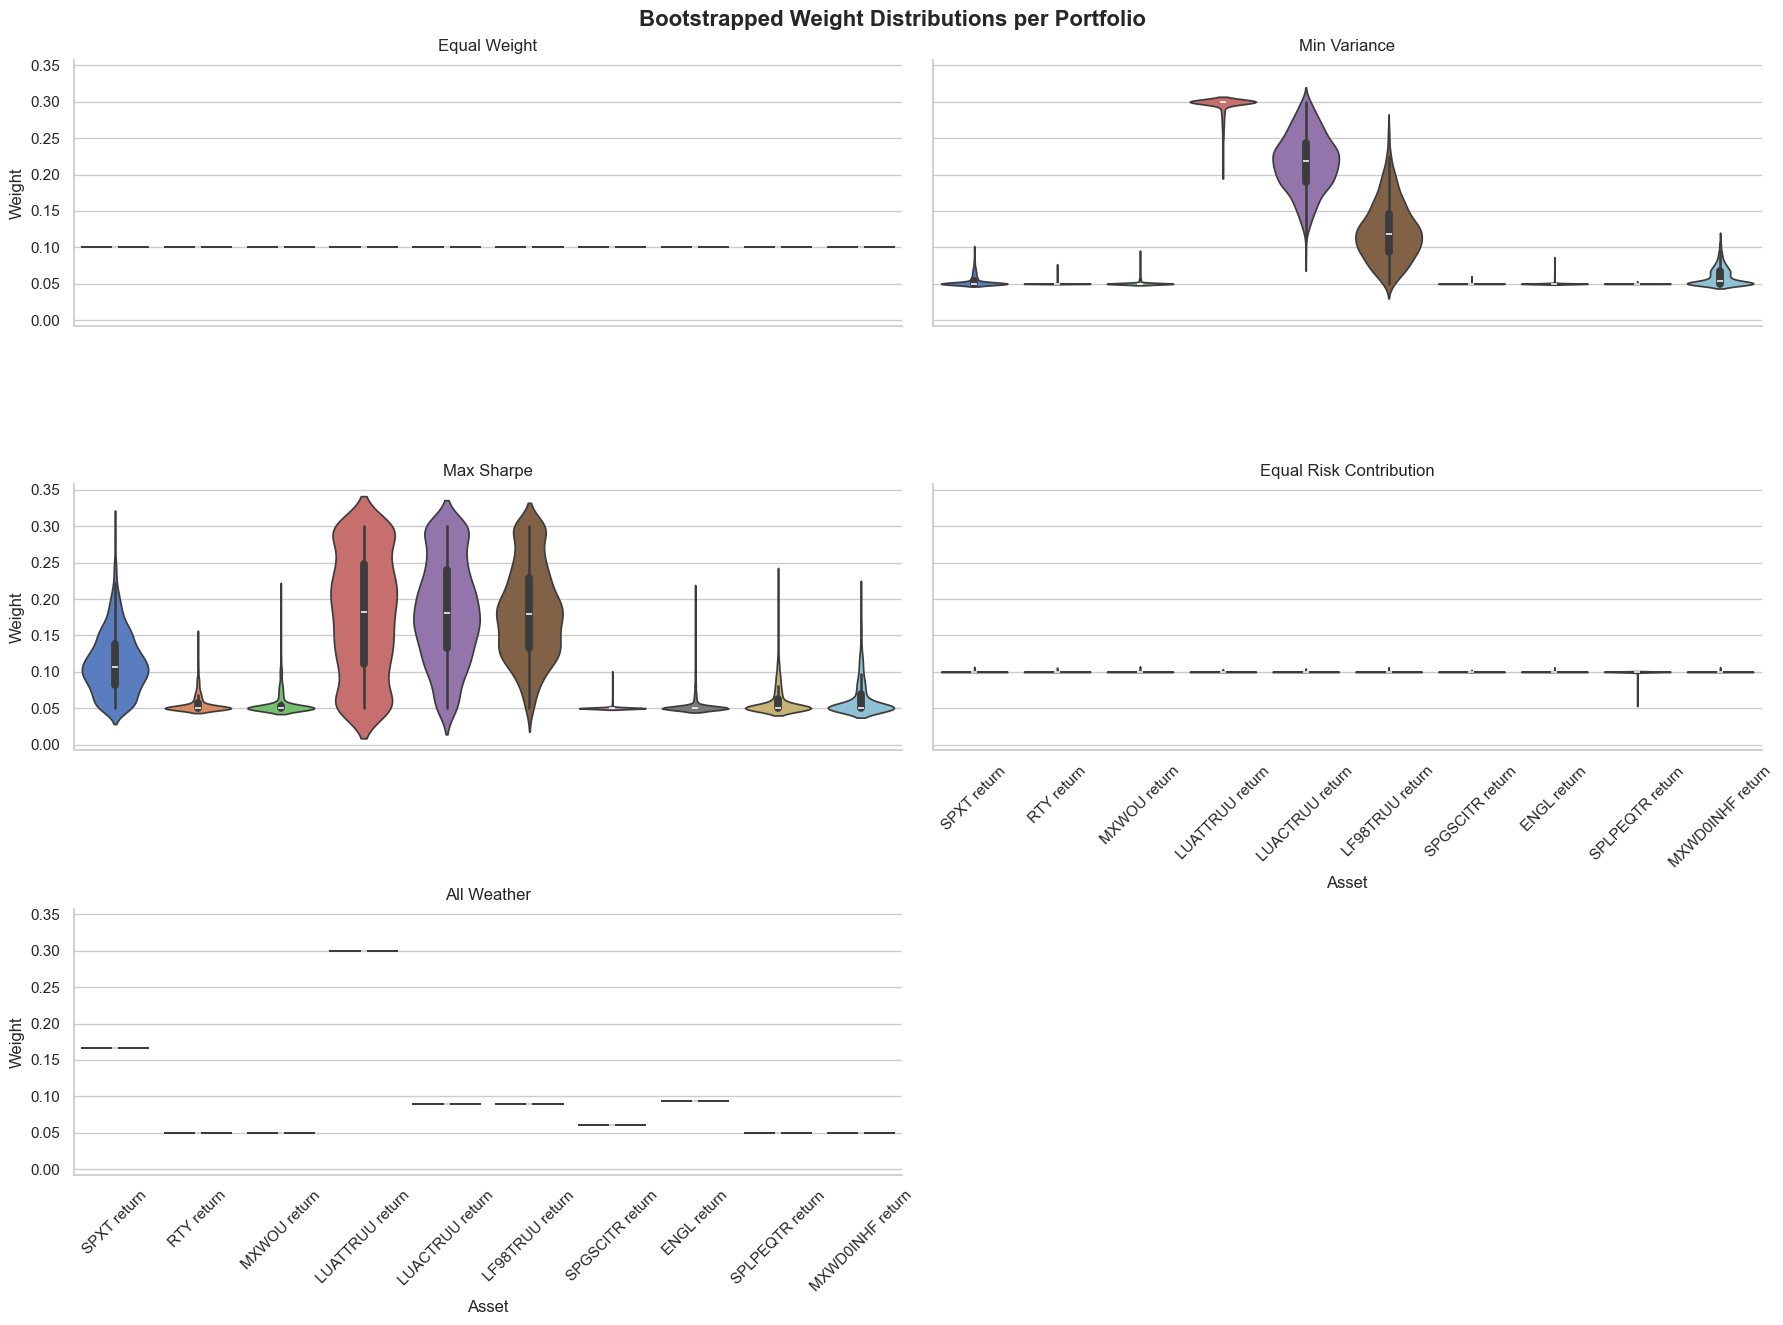

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use the same melted DataFrame from earlier: df_all_melted

# Set up color palette for clarity
palette = {
    "Equal Weight": "#1f77b4",
    "Min Variance": "#ff7f0e",
    "Max Sharpe": "#2ca02c",
    "Equal Risk Contribution": "#d62728",
    "All Weather": "#9467bd"
}

# Create FacetGrid for each portfolio
g = sns.FacetGrid(df_all_melted, col="Portfolio", col_wrap=2, height=4.5, aspect=2, sharey=True)
g.map(sns.violinplot, "Asset", "Weight", order=columns, palette="muted")
g.set_titles("{col_name}")
g.set_axis_labels("Asset", "Weight")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Bootstrapped Weight Distributions per Portfolio", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


In [99]:
# Compute ERC weights (already averaged)
avg_weights_erc = df_weights_erc.mean().values

# Full covariance matrix
cov_matrix = ptf_returns.cov().values

# Portfolio volatility
port_vol = np.sqrt(avg_weights_erc.T @ cov_matrix @ avg_weights_erc)

# Marginal contribution to risk
marginal_contrib = cov_matrix @ avg_weights_erc

# Risk contributions
risk_contributions = avg_weights_erc * marginal_contrib / port_vol

# Normalize to percentage of total risk
risk_contributions_pct = risk_contributions / port_vol

# Format as DataFrame
df_risk_contrib_erc = pd.DataFrame({
    'Weight': avg_weights_erc,
    'Risk Contribution': risk_contributions,
    'Risk Contribution %': risk_contributions_pct
}, index=columns).sort_values(by='Risk Contribution %', ascending=False)

display(df_risk_contrib_erc.style.format({"Weight": "{:.2%}", "Risk Contribution %": "{:.1%}"}))


"Can the introduction of a long volatility asset help the optimal portfolio weather market turbulence: A cost-benefit analysis?

In [50]:
def compute_hhi(weights_df):
    """
    Computes the Herfindahl-Hirschman Index (HHI) across bootstrapped samples.
    
    Parameters:
        weights_df (pd.DataFrame): Bootstrapped weights for a portfolio (shape: n_samples x n_assets)

    Returns:
        pd.Series: HHI value for each bootstrap sample
    """
    return (weights_df ** 2).sum(axis=1)


In [51]:
# HHI for each portfolio
hhi_equal     = compute_hhi(df_weights_equal)
hhi_minvar    = compute_hhi(df_weights_minvar)
hhi_maxsharpe = compute_hhi(df_weights_maxsharpe)
hhi_erc       = compute_hhi(df_weights_erc)
hhi_allw      = compute_hhi(df_weights_allweather)


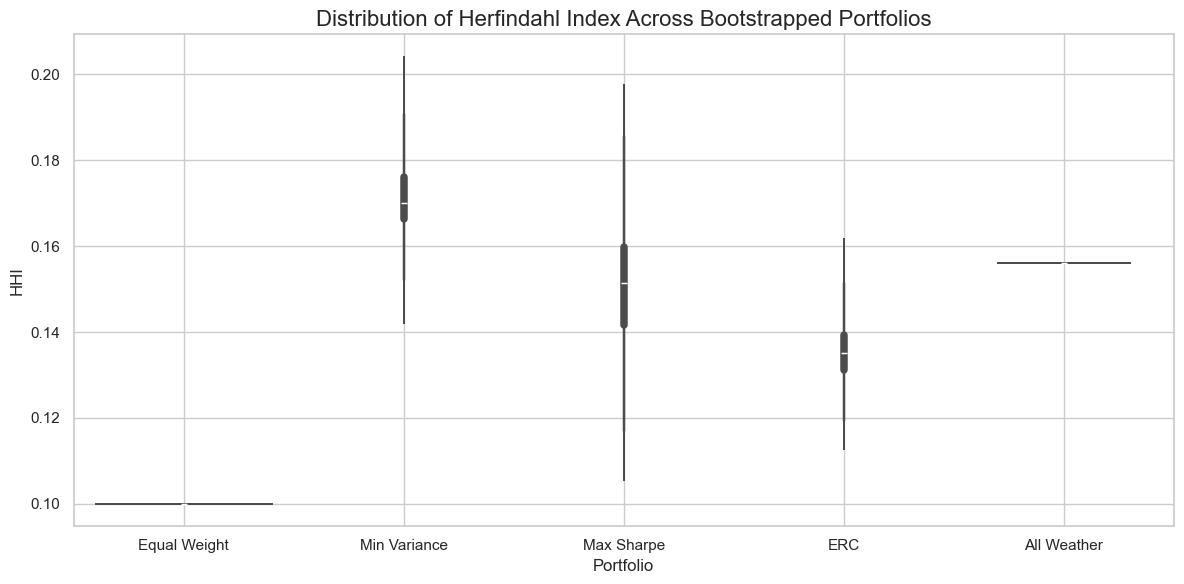

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine into DataFrame for plotting
hhi_df = pd.DataFrame({
    "Equal Weight": hhi_equal,
    "Min Variance": hhi_minvar,
    "Max Sharpe": hhi_maxsharpe,
    "ERC": hhi_erc,
    "All Weather": hhi_allw
})

# Melt for seaborn
hhi_melted = hhi_df.melt(var_name='Portfolio', value_name='HHI')

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=hhi_melted, x='Portfolio', y='HHI', inner='box', linewidth=1.2)
plt.title("Distribution of Herfindahl Index Across Bootstrapped Portfolios", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
# Compute the Herfindahl-Hirschman Index (HHI) for each bootstrapped portfolio
def compute_hhi(weights_df):
    return (weights_df ** 2).sum(axis=1)

# Compute HHI distributions
hhi_equal     = compute_hhi(df_weights_equal)
hhi_minvar    = compute_hhi(df_weights_minvar)
hhi_maxsharpe = compute_hhi(df_weights_maxsharpe)
hhi_erc       = compute_hhi(df_weights_erc)
hhi_allw      = compute_hhi(df_weights_allweather)

# Summarize each HHI distribution with mean, std, min, max
hhi_summary = pd.DataFrame({
    "Equal Weight": [hhi_equal.mean(), hhi_equal.std(), hhi_equal.min(), hhi_equal.max()],
    "Min Variance": [hhi_minvar.mean(), hhi_minvar.std(), hhi_minvar.min(), hhi_minvar.max()],
    "Max Sharpe": [hhi_maxsharpe.mean(), hhi_maxsharpe.std(), hhi_maxsharpe.min(), hhi_maxsharpe.max()],
    "ERC": [hhi_erc.mean(), hhi_erc.std(), hhi_erc.min(), hhi_erc.max()],
    "All Weather": [hhi_allw.mean(), hhi_allw.std(), hhi_allw.min(), hhi_allw.max()]
}, index=["Mean", "Std", "Min", "Max"]).T

# Simply display the DataFrame in Jupyter
display(hhi_summary)



Mean           Std       Min       Max
Equal Weight  0.100000  1.444012e-15  0.100000  0.100000
Min Variance  0.171845  8.113473e-03  0.146091  0.200000
Max Sharpe    0.150879  1.300430e-02  0.112010  0.190912
ERC           0.135516  6.732877e-03  0.116225  0.158354
All Weather   0.156143  2.054940e-15  0.156143  0.156143

In [55]:
# Compute standard deviation of each asset's weights across bootstrapped samples
std_weights_equal     = df_weights_equal.std().sort_index()
std_weights_minvar    = df_weights_minvar.std().sort_index()
std_weights_maxsharpe = df_weights_maxsharpe.std().sort_index()
std_weights_erc       = df_weights_erc.std().sort_index()
std_weights_allw      = df_weights_allweather.std().sort_index()

# Combine into a single DataFrame for comparison
weight_dispersion_df = pd.DataFrame({
    "Equal Weight": std_weights_equal,
    "Min Variance": std_weights_minvar,
    "Max Sharpe": std_weights_maxsharpe,
    "Equal Risk Contribution": std_weights_erc,
    "All Weather": std_weights_allw
})

# Display or export to Excel
display(weight_dispersion_df)
# weight_dispersion_df.to_excel("Weight_Dispersion_Std.xlsx", sheet_name="Std Deviation of Weights")


Equal Weight  Min Variance  Max Sharpe  \
ENGL return       1.416243e-15      0.002297    0.011530   
LF98TRUU return   1.416243e-15      0.039924    0.063979   
LUACTRUU return   1.416243e-15      0.039122    0.071180   
LUATTRUU return   1.416243e-15      0.013453    0.082174   
MXWD0INHF return  1.416243e-15      0.012869    0.025538   
MXWOU return      1.416243e-15      0.004139    0.015929   
RTY return        1.416243e-15      0.001050    0.013111   
SPGSCITR return   1.416243e-15      0.000334    0.004095   
SPLPEQTR return   1.416243e-15      0.000147    0.019625   
SPXT return       1.416243e-15      0.007466    0.043012   

                  Equal Risk Contribution   All Weather  
ENGL return                      0.009667  1.596744e-15  
LF98TRUU return                  0.025822  1.721707e-15  
LUACTRUU return                  0.026221  1.638398e-15  
LUATTRUU return                  0.044404  5.664971e-15  
MXWD0INHF return                 0.012007  7.220061e-16  
MXWOU return                     0.010386  7.289484e-16  
RTY return                       0.007100  7.220061e-16  
SPGSCITR return                  0.004939  1.145490e-15  
SPLPEQTR return                  0.004881  7.081213e-16  
SPXT return                      0.011369  1.194087e-15

Equal Weight & All Weather: Have near-zero standard deviation. Why? They’re fixed-weight portfolios, so bootstrapping has no effect on their weights.

Min Variance & Max Sharpe: Show meaningful dispersion, especially in:

LUATTRUU, LUACTRUU, LF98TRUU — these are bond-like assets, suggesting they're key drivers of optimization variability.

ERC: Has moderate variability — that’s normal, as the optimization adjusts to match risk rather than return or variance.

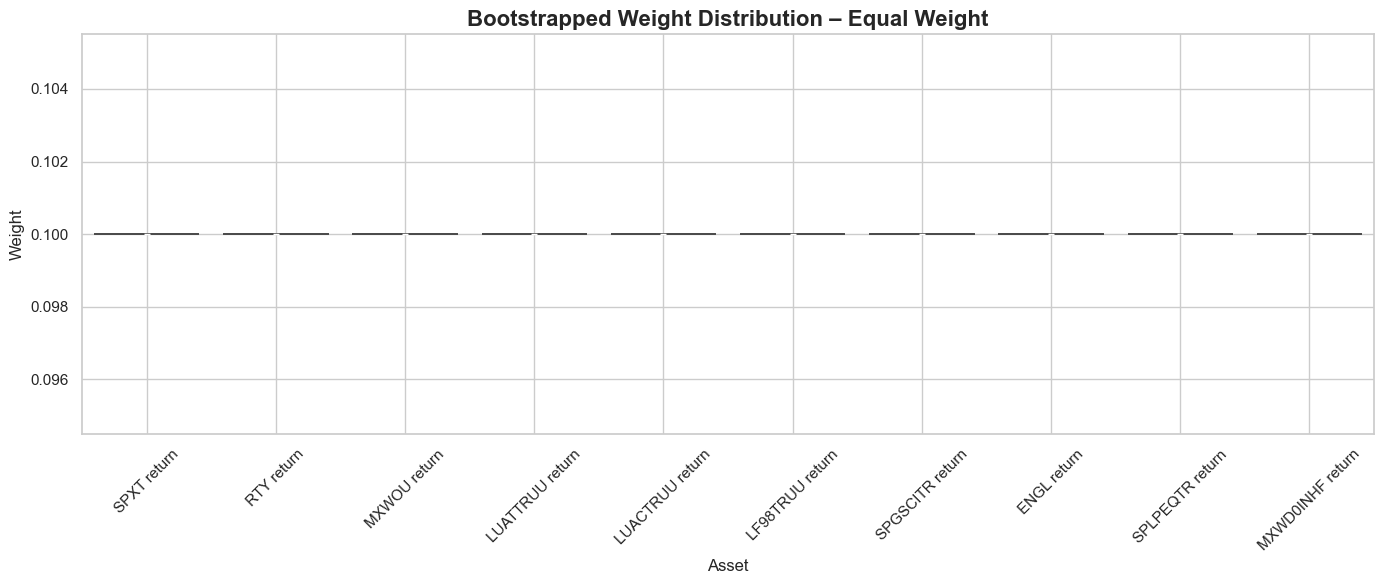

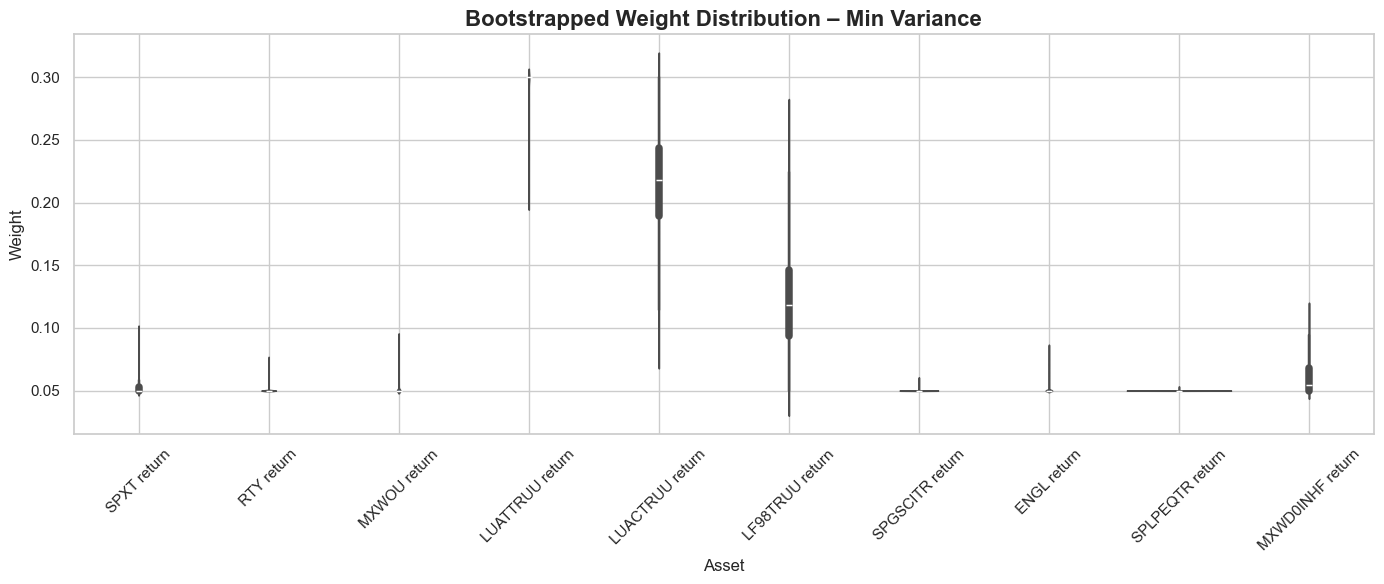

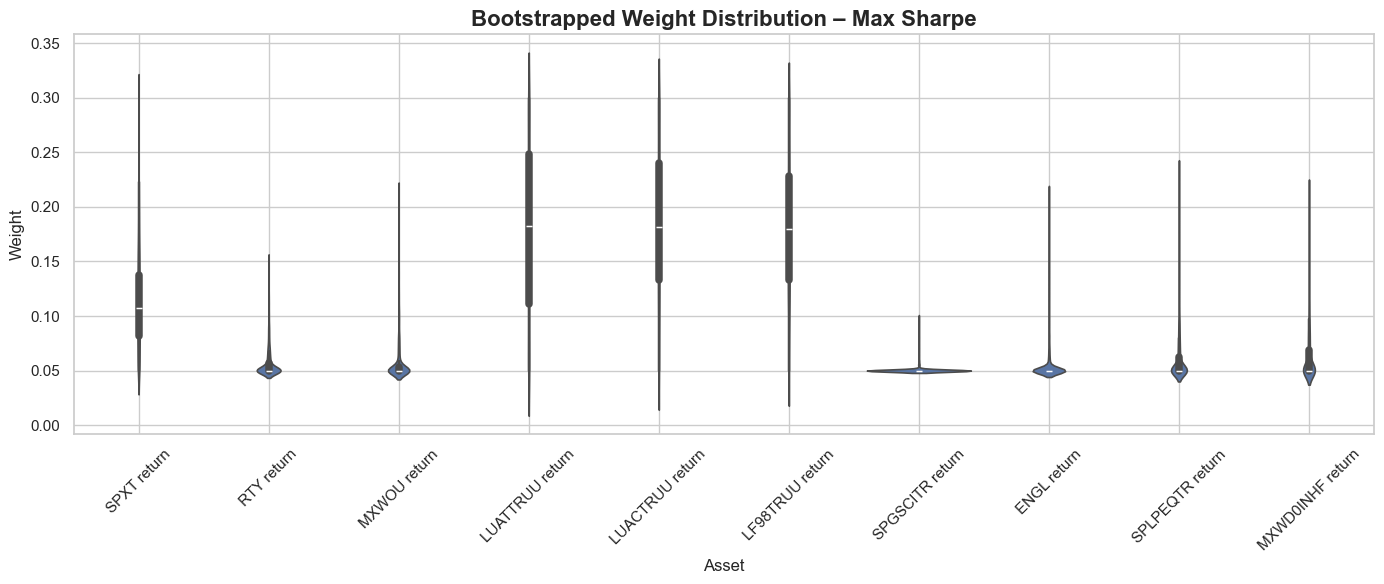

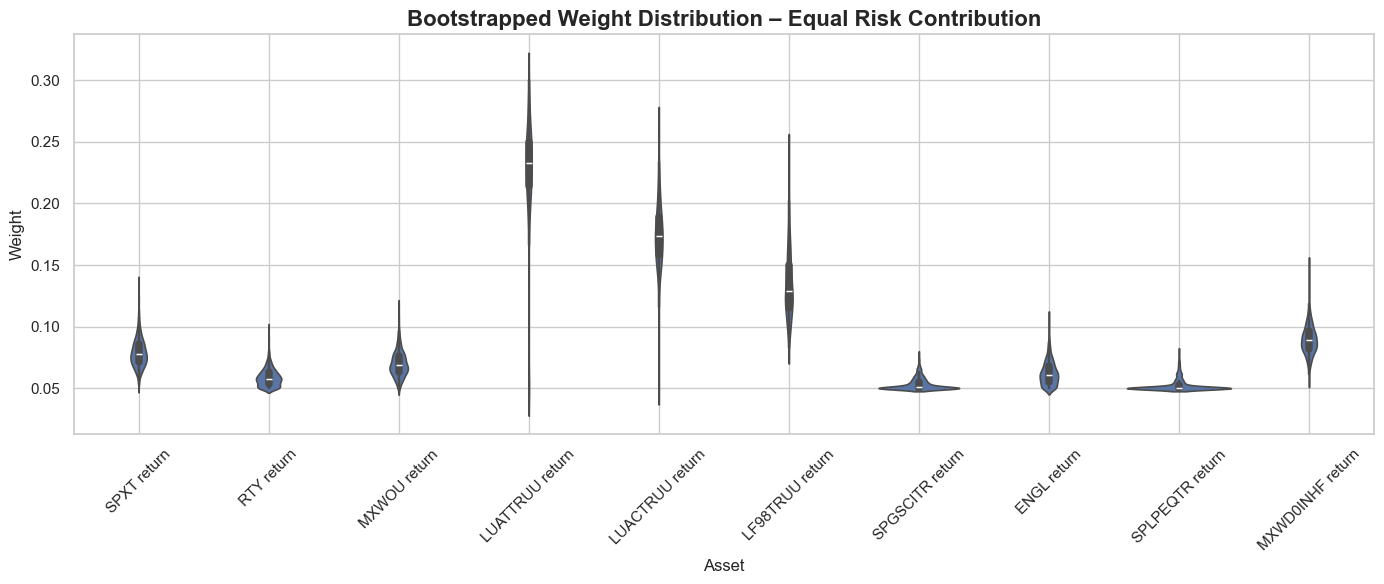

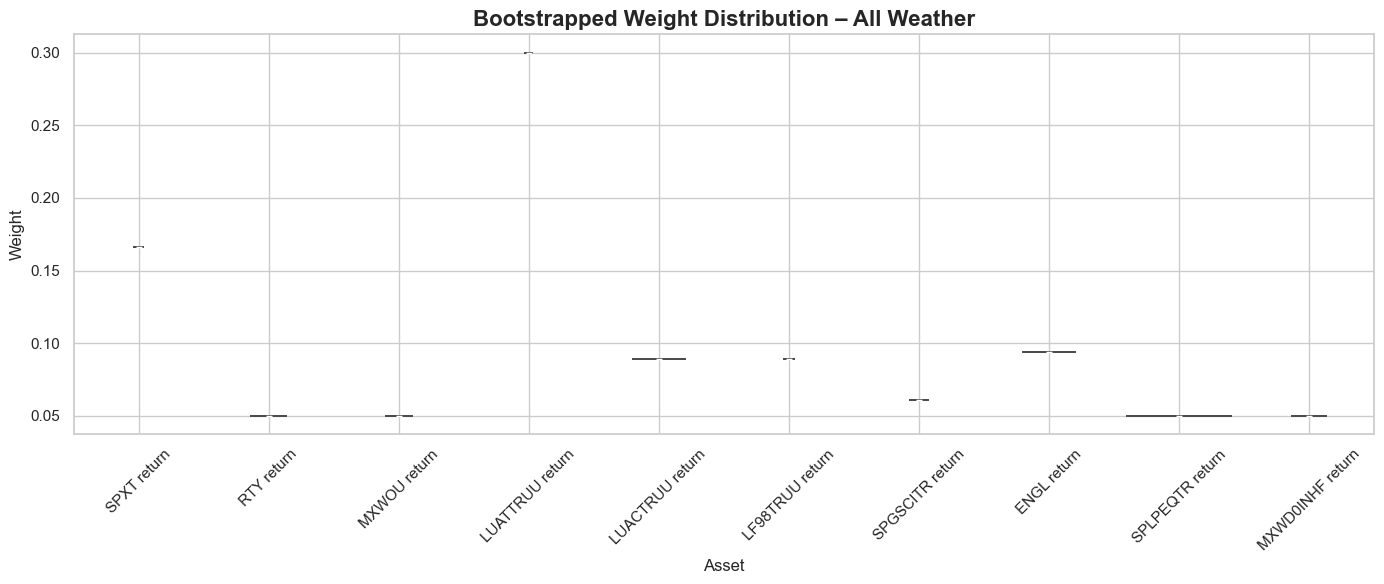

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define portfolio names and DataFrames
portfolio_dict = {
    "Equal Weight": df_weights_equal,
    "Min Variance": df_weights_minvar,
    "Max Sharpe": df_weights_maxsharpe,
    "Equal Risk Contribution": df_weights_erc,
    "All Weather": df_weights_allweather
}

# Plot each portfolio separately
for name, df in portfolio_dict.items():
    plt.figure(figsize=(14, 6))
    melted_df = df.melt(var_name="Asset", value_name="Weight")

    sns.violinplot(data=melted_df, x="Asset", y="Weight", inner="box", linewidth=1.2)
    plt.title(f"Bootstrapped Weight Distribution – {name}", fontsize=16, weight="bold")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


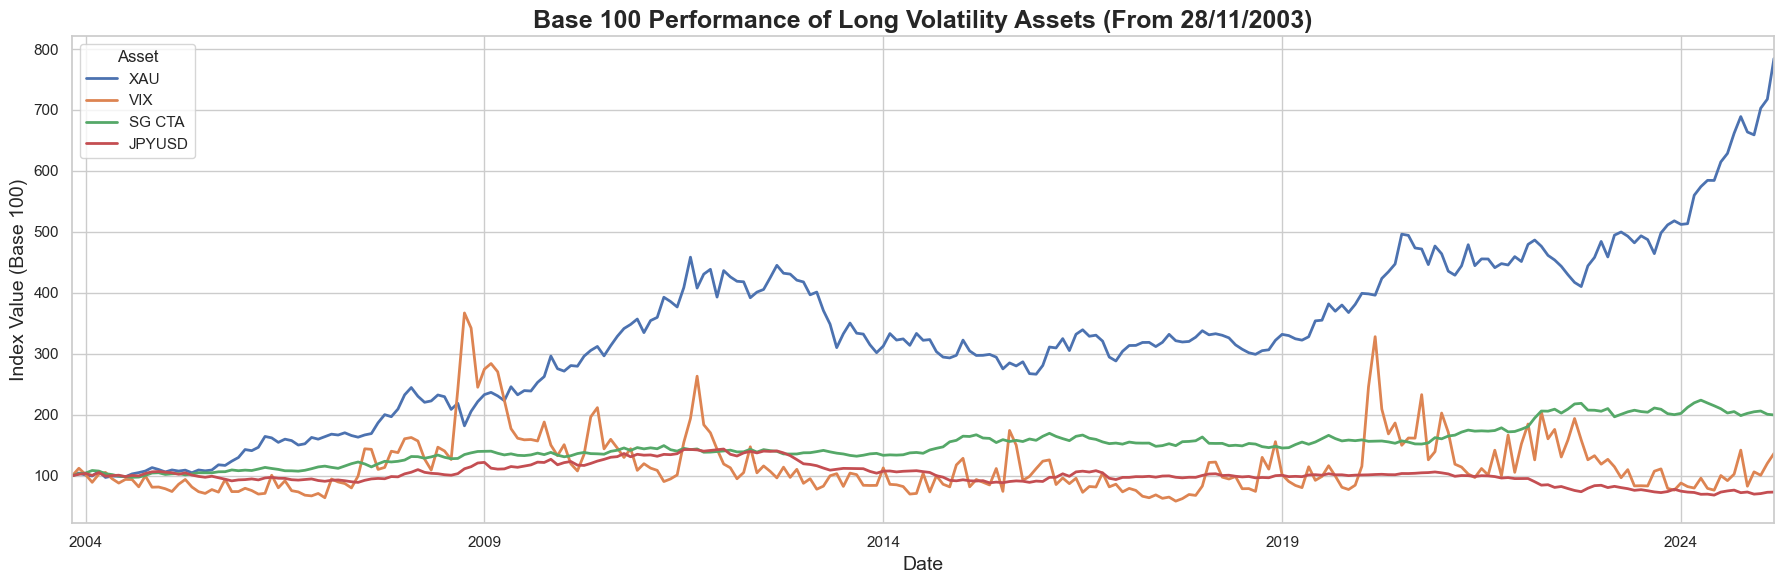

CAGR  Total Return  Annualized Volatility  Sharpe Ratio (Adj RF)
XAU     0.101346     -0.872534               0.001663              51.130512
VIX     0.014695     -0.267504               0.008442              -0.194467
SG CTA  0.032937     -0.499182               0.000809              20.524620
JPYUSD -0.014578      0.368026               0.000952             -32.478118

In [70]:
# Re-import required packages after kernel reset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the re-uploaded Excel file
file_path = "data indices.xlsx"
xls = pd.ExcelFile(file_path)

# Load and clean the 'all returns' sheet
df_all = xls.parse("all returns")
df_all.columns = df_all.columns.str.strip()
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all.set_index('Date', inplace=True)

# Filter from 28/11/2003
df_all = df_all[df_all.index >= pd.to_datetime("2003-11-28")]

# Select only the 'perf' columns for long vol assets
perf_cols = [col for col in df_all.columns if 'perf' in col and any(asset in col for asset in ['XAU', 'VIX', 'SG CTA', 'JPYUSD'])]
df_perf = df_all[perf_cols]
df_perf.columns = [col.replace(' perf', '') for col in df_perf.columns]

# Plot base 100 performance
plt.figure(figsize=(18, 6))
df_perf.plot(ax=plt.gca(), linewidth=2)
plt.title("Base 100 Performance of Long Volatility Assets (From 28/11/2003)", fontsize=18, weight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Index Value (Base 100)", fontsize=14)
plt.grid(True)
plt.legend(title="Asset", fontsize=11)
plt.tight_layout()
plt.show()

df_main = xls.parse("main ptfs")
df_main['Date'] = pd.to_datetime(df_main['Date'])
df_main.set_index('Date', inplace=True)

# Extract annualized risk-free rate series
risk_free_series = df_main['3M UST']
annualized_rf = risk_free_series.mean()

# Parse 'all returns' sheet to get long vol assets
df_all = xls.parse("all returns")
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all.set_index('Date', inplace=True)

# Extract only the long vol asset returns
long_vol_cols = ['XAU return', 'VIX return', 'SG CTA return', 'JPYUSD return']
df_lv = df_all[long_vol_cols].dropna()

# Compute statistics
stats = {}
for col in df_lv.columns:
    total_return = (1 + df_lv[col]).prod() - 1
    n_years = (df_lv.index[-1] - df_lv.index[0]).days / 365.25
    cagr = (1 + total_return) ** (1 / n_years) - 1
    ann_vol = df_lv[col].std() * (12 ** 0.5)  # Monthly to annual
    sharpe = (cagr - annualized_rf) / ann_vol if ann_vol != 0 else float('nan')
    stats[col.split()[0]] = {
        'CAGR': cagr,
        'Total Return': total_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio (Adj RF)': sharpe
    }


display(stats_df)



In [73]:
import pandas as pd

# Load the latest uploaded Excel file and select relevant sheet and columns
file_path = "data indices.xlsx"
xls = pd.ExcelFile(file_path)

# Parse the 'main ptfs' sheet and clean it
df_main = xls.parse("main ptfs")
df_main['Date'] = pd.to_datetime(df_main['Date'])
df_main.set_index('Date', inplace=True)

# Extract annualized risk-free rate series
risk_free_series = df_main['3M UST']
annualized_rf = risk_free_series.mean()

# Parse 'all returns' sheet to get long vol assets
df_all = xls.parse("all returns")
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all.set_index('Date', inplace=True)

# Extract only the long vol asset returns
long_vol_cols = ['XAU return', 'VIX return', 'SG CTA return', 'JPYUSD return']
df_lv = df_all[long_vol_cols].dropna()

# Compute statistics
stats = {}
for col in df_lv.columns:
    total_return = (1 + df_lv[col]).prod() - 1
    n_years = (df_lv.index[-1] - df_lv.index[0]).days / 365.25
    cagr = (1 + total_return) ** (1 / n_years) - 1
    ann_vol = df_lv[col].std() * (12 ** 0.5)  # Monthly to annual
    sharpe = (cagr - annualized_rf) / ann_vol if ann_vol != 0 else float('nan')
    stats[col.split()[0]] = {
        'CAGR': cagr,
        'Total Return': total_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio (Adj RF)': sharpe
    }

display(stats_df)


CAGR  Total Return  Annualized Volatility  Sharpe Ratio (Adj RF)
XAU    -0.090382      9.845729               0.160848              -0.663308
VIX     0.004009     -0.095779               0.808116              -0.015221
SG     -0.040590      1.836877               0.087234              -0.652263
JPYUSD  0.015234     -0.316453               0.096433              -0.011145

/var/folders/8z/c993dyxd7_7192clm2cw4qyr0000gn/T/ipykernel_72946/2912028528.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_series = rf_series.reindex(long_vol_returns.index).fillna(method='ffill')


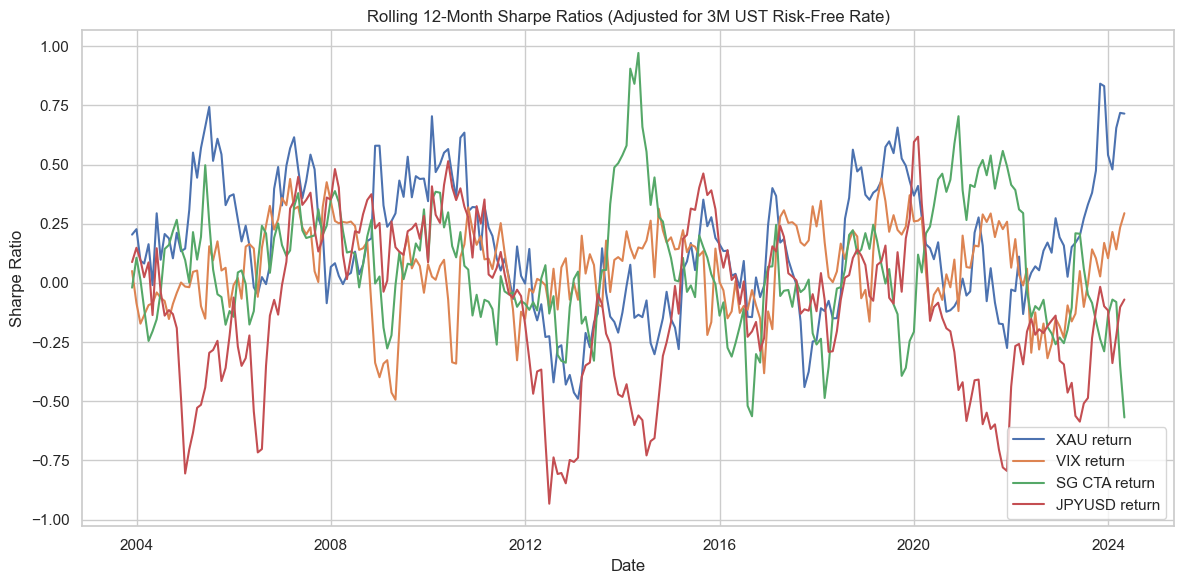

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
excel_path = "data indices.xlsx"  # Replace with the full path if needed
long_vol_df = pd.read_excel(excel_path, sheet_name='all returns', index_col=0, parse_dates=True)
main_ptfs_df = pd.read_excel(excel_path, sheet_name='main ptfs', index_col=0, parse_dates=True)

# Extract monthly return data for long volatility assets
long_vol_returns = long_vol_df[['XAU return', 'VIX return', 'SG CTA return', 'JPYUSD return']]

# Filter starting from 28/11/2003
long_vol_returns = long_vol_returns[long_vol_returns.index >= pd.Timestamp("2003-11-28")]

# Extract risk-free rate (annualized 3M UST), convert to monthly rate
rf_series = main_ptfs_df["3M UST"] / 12
rf_series = rf_series.reindex(long_vol_returns.index).fillna(method='ffill')

# Compute excess returns
excess_returns = long_vol_returns.sub(rf_series, axis=0)

# Compute rolling 12-month Sharpe ratios
rolling_sharpe = excess_returns.rolling(window=12).mean() / excess_returns.rolling(window=12).std()

# Plotting the results
plt.figure(figsize=(12, 6))
for asset in rolling_sharpe.columns:
    plt.plot(rolling_sharpe.index, rolling_sharpe[asset], label=asset)

plt.title("Rolling 12-Month Sharpe Ratios (Adjusted for 3M UST Risk-Free Rate)")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/8z/c993dyxd7_7192clm2cw4qyr0000gn/T/ipykernel_72946/2912028528.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_series = rf_series.reindex(long_vol_returns.index).fillna(method='ffill')


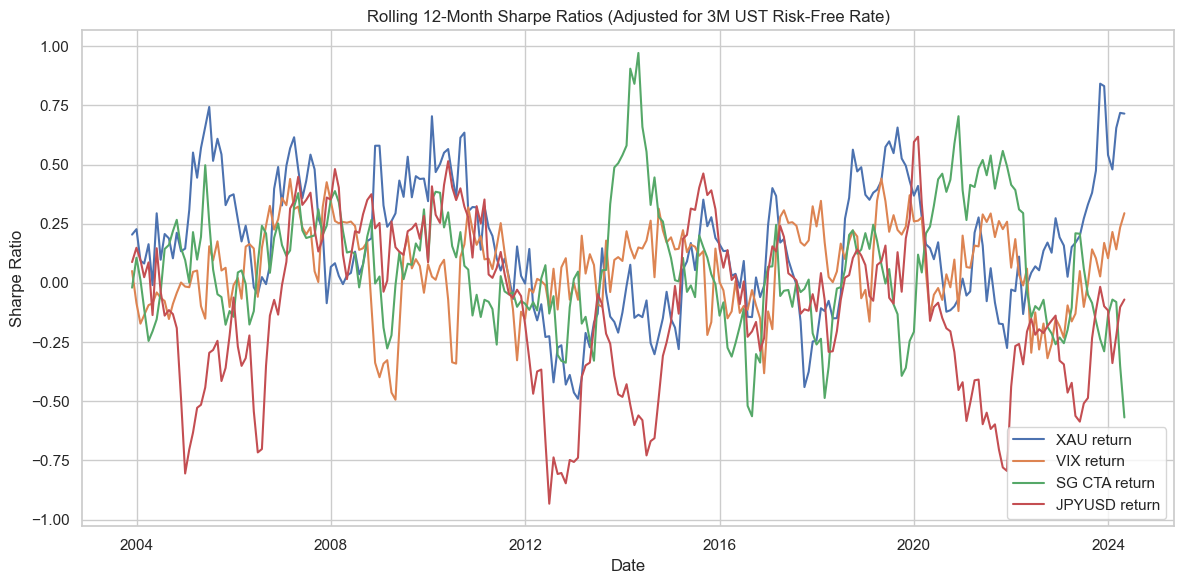

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
excel_path = "data indices.xlsx"  # Replace with the full path if needed
long_vol_df = pd.read_excel(excel_path, sheet_name='all returns', index_col=0, parse_dates=True)
main_ptfs_df = pd.read_excel(excel_path, sheet_name='main ptfs', index_col=0, parse_dates=True)

# Extract monthly return data for long volatility assets
long_vol_returns = long_vol_df[['XAU return', 'VIX return', 'SG CTA return', 'JPYUSD return']]

# Filter starting from 28/11/2003
long_vol_returns = long_vol_returns[long_vol_returns.index >= pd.Timestamp("2003-11-28")]

# Extract risk-free rate (annualized 3M UST), convert to monthly rate
rf_series = main_ptfs_df["3M UST"] / 12
rf_series = rf_series.reindex(long_vol_returns.index).fillna(method='ffill')

# Compute excess returns
excess_returns = long_vol_returns.sub(rf_series, axis=0)

# Compute rolling 12-month Sharpe ratios
rolling_sharpe = excess_returns.rolling(window=12).mean() / excess_returns.rolling(window=12).std()

# Plotting the results
plt.figure(figsize=(12, 6))
for asset in rolling_sharpe.columns:
    plt.plot(rolling_sharpe.index, rolling_sharpe[asset], label=asset)

plt.title("Rolling 12-Month Sharpe Ratios (Adjusted for 3M UST Risk-Free Rate)")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


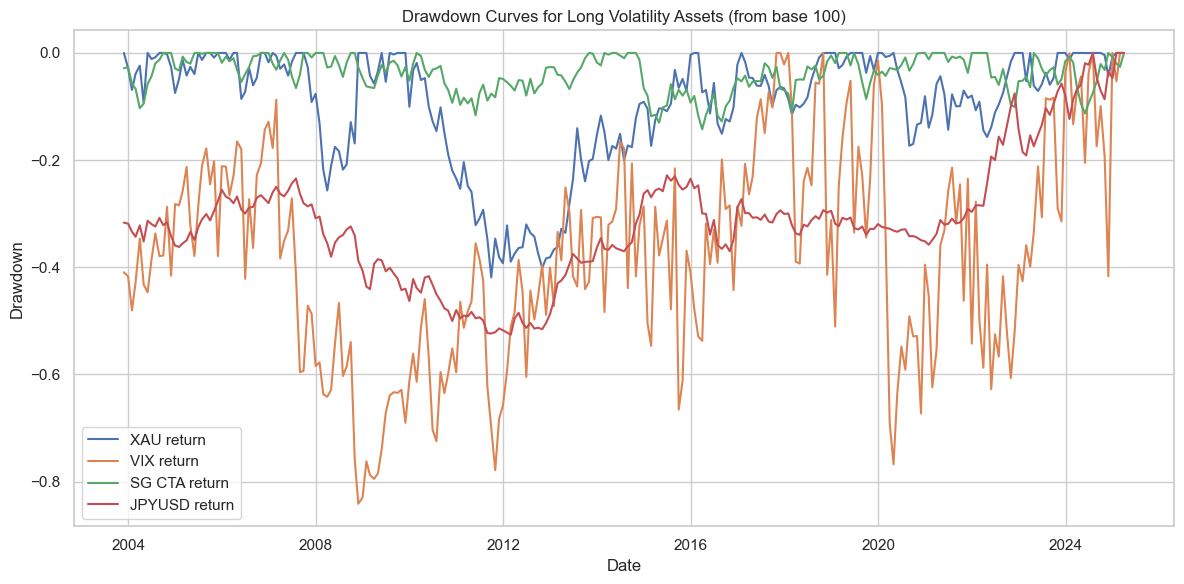

In [77]:
import numpy as np

# Reuse long_vol_returns from earlier step (make sure it's already filtered from 2003-11-28)
# Compute cumulative performance (base 100)
cumulative_returns = (1 + long_vol_returns).cumprod() * 100

# Compute rolling maximum of cumulative returns
rolling_max = cumulative_returns.cummax()

# Compute drawdown
drawdowns = (cumulative_returns - rolling_max) / rolling_max

# Plotting
plt.figure(figsize=(12, 6))
for asset in drawdowns.columns:
    plt.plot(drawdowns.index, drawdowns[asset], label=asset)

plt.title("Drawdown Curves for Long Volatility Assets (from base 100)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [90]:
pip install cvxpy


Note: you may need to restart the kernel to use updated packages.


In [113]:
# Check shape of first sample in each column
for col in columns_gold:
    print(f"{col}: {[type(boot_gold[col][i]) for i in range(3)]}")
    print(f"{col} sample shapes: {[np.array(boot_gold[col][i]).shape for i in range(3)]}")


SPXT return: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
SPXT return sample shapes: [(257,), (257,), (257,)]
RTY return: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
RTY return sample shapes: [(257,), (257,), (257,)]
MXWOU return: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
MXWOU return sample shapes: [(257,), (257,), (257,)]
LUATTRUU return: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
LUATTRUU return sample shapes: [(257,), (257,), (257,)]
LUACTRUU return: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
LUACTRUU return sample shapes: [(257,), (257,), (257,)]
LF98TRUU return: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
LF98TRUU return sample shapes: [(257,), (257,), (257,)]
SPGSCITR return: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
SPGSCITR return sample shapes: [(257,

In [118]:
print(ptf_data_df.columns.tolist())


['SPXT return', 'SPXT perf', 'RTY return', 'RTY perf', 'MXWOU return', 'MXWOU perf', 'LUATTRUU return', 'LUATTRUU perf', 'LUACTRUU return', 'LUACTRUU perf', 'LF98TRUU return', 'LF98TRUU perf', 'SPGSCITR return', 'SPGSCITR perf', 'ENGL return', 'ENGL perf', 'SPLPEQTR return', 'SPLPEQTR perf', 'MXWD0INHF return', 'MXWD0INHF perf', '3M USD']


In [122]:
import numpy as np
from scipy.optimize import minimize

# === Portfolio Optimization Objectives ===
def portfolio_performance(weights, returns, rf_rate=0.016309042801556418):
    port_return = np.dot(weights, returns.mean()) * 12
    port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 12, weights)))
    sharpe = (port_return - rf_rate) / port_vol if port_vol != 0 else 0
    return port_return, port_vol, sharpe

def min_variance_objective(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def negative_sharpe_objective(weights, mean_returns, cov_matrix, rf_rate=0):
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(port_return - rf_rate) / port_vol if port_vol != 0 else 0

def risk_contribution(weights, cov_matrix):
    sigma = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    marginal_contrib = np.dot(cov_matrix, weights)
    risk_contrib = weights * marginal_contrib / sigma
    return risk_contrib

def erc_objective(weights, cov_matrix):
    rc = risk_contribution(weights, cov_matrix)
    return np.sum((rc - rc.mean())**2)

def optimize_portfolio(returns, objective='minvar', rf_rate=0.0):
    n_assets = returns.shape[1]
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    bounds = [(0.05, 0.30)] * n_assets
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    x0 = np.array([1/n_assets]*n_assets)

    if objective == 'minvar':
        result = minimize(min_variance_objective, x0, args=(cov_matrix,), method='SLSQP',
                          bounds=bounds, constraints=constraints)
    elif objective == 'maxsharpe':
        result = minimize(negative_sharpe_objective, x0, args=(mean_returns, cov_matrix, rf_rate),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    elif objective == 'erc':
        result = minimize(erc_objective, x0, args=(cov_matrix,), method='SLSQP',
                          bounds=bounds, constraints=constraints)
    elif objective == 'allweather':
        inverse_vol = 1 / np.sqrt(np.diag(cov_matrix))
        weights = inverse_vol / np.sum(inverse_vol)
        weights = np.clip(weights, 0.05, 0.30)
        weights = weights / weights.sum()
        return weights
    elif objective == 'equal':
        return np.array([1/n_assets]*n_assets)
    else:
        raise ValueError("Unknown objective type.")

    if result.success:
        return result.x
    else:
        raise RuntimeError(f"Optimization failed for {objective}: {result.message}")

# === Bootstrapping Portfolio Weights ===
def bootstrap_portfolio(returns, objective, rf_rate=0.0, n_samples=10000):
    weights_list = []
    np.random.seed(42)

    for _ in range(n_samples):
        sample = returns.sample(frac=1, replace=True)
        try:
            weights = optimize_portfolio(sample, objective=objective, rf_rate=rf_rate)
            weights_list.append(weights)
        except RuntimeError:
            continue  # skip failed samples

    weights_array = np.array(weights_list)
    return weights_array, weights_array.mean(axis=0), np.std(weights_array, axis=0)

# === Portfolio Performance Helper ===
def compute_base100_performance(returns, weights):
    portfolio_returns = returns @ weights
    base100 = (1 + portfolio_returns).cumprod() * 100
    return base100

def herfindahl_index(weights):
    return np.sum(np.square(weights))


In [127]:
# === Load 'all returns' sheet from 'data indices.xlsx' ===
file_path = "data indices.xlsx"  # or the correct relative path if different
all_returns_df = pd.read_excel(file_path, sheet_name="all returns", index_col=0)
all_returns_df.index = pd.to_datetime(all_returns_df.index)
all_returns_df.sort_index(inplace=True)

# === 1. EXTEND UNIVERSE WITH GOLD ===
extended_returns = all_returns_df[[
    'SPXT return', 'RTY return', 'MXWOU return', 'LUATTRUU return', 'LUACTRUU return',
    'LF98TRUU return', 'SPGSCITR return', 'ENGL return', 'SPLPEQTR return', 'MXWD0INHF return', 'XAU return'
]].dropna()

extended_returns.columns = [col.replace(" return", "") for col in extended_returns.columns]

# Align 3M UST to return index and convert to monthly
rf_series = ptf_data_df['3M USD'].loc[extended_returns.index]
rf_monthly = rf_series / 100  # assuming it's annualized %

# === 2. COMPUTE PORTFOLIOS WITH GOLD ===
objectives = ['equal', 'minvar', 'maxsharpe', 'erc', 'allweather']
bootstrapped_results = {}

for obj in objectives:
    boot_weights, avg_weights, std_weights = bootstrap_portfolio(
        extended_returns, objective=obj, rf_rate=rf_monthly.mean(), n_samples=10000
    )
    base100 = compute_base100_performance(extended_returns, avg_weights)
    herf = herfindahl_index(avg_weights)
    portfolio_returns = extended_returns @ avg_weights
    max_dd = ((1 + portfolio_returns).cumprod().cummax() - (1 + portfolio_returns).cumprod()).max()
    ann_return = portfolio_returns.mean() * 12
    ann_vol = portfolio_returns.std() * np.sqrt(12)
    sharpe = (ann_return - rf_monthly.mean() * 12) / ann_vol

    bootstrapped_results[obj] = {
        "avg_weights": avg_weights,
        "std_weights": std_weights,
        "performance": base100,
        "herfindahl": herf,
        "sharpe": sharpe,
        "ann_return": ann_return,
        "ann_vol": ann_vol,
        "max_drawdown": -max_dd
    }

# Show asset weights table
summary_maxsharpe_gold = pd.DataFrame({
    "Average Weight": bootstrapped_results['maxsharpe']['avg_weights'],
    "Std of Weights": bootstrapped_results['maxsharpe']['std_weights']
}, index=extended_returns.columns).round(5)

display(summary_maxsharpe_gold)

# Show portfolio-level metrics
summary_stats = {
    "Herfindahl Index": bootstrapped_results['maxsharpe']['herfindahl'],
    "Annual Sharpe": bootstrapped_results['maxsharpe']['sharpe'],
    "Ann Return": bootstrapped_results['maxsharpe']['ann_return'],
    "Ann Volatility": bootstrapped_results['maxsharpe']['ann_vol'],
    "Max Drawdown": bootstrapped_results['maxsharpe']['max_drawdown']
}

print("📊 Portfolio-Level Metrics (Max Sharpe with Gold):")
for k, v in summary_stats.items():
    print(f"{k}: {v:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


Average Weight  Std of Weights
SPXT              0.12913         0.09485
RTY               0.05045         0.00773
MXWOU             0.05000         0.00000
LUATTRUU          0.16132         0.09987
LUACTRUU          0.05888         0.03715
LF98TRUU          0.11358         0.09252
SPGSCITR          0.05110         0.00972
ENGL              0.05000         0.00000
SPLPEQTR          0.05090         0.01131
MXWD0INHF         0.05000         0.00010
XAU               0.23464         0.08207

📊 Portfolio-Level Metrics (Max Sharpe with Gold):
Herfindahl Index: 0.1294
Annual Sharpe: 0.7552
Ann Return: 0.0728
Ann Volatility: 0.0938
Max Drawdown: -0.5765


In [130]:
# === REPEAT FOR OTHER LONG VOL ASSETS ===
other_lv_assets = ['VIX return', 'SG CTA return', 'JPYUSD return']
bootstrapped_results_lv = {}
traditional_assets = [
    'SPXT return', 'RTY return', 'MXWOU return', 'LUATTRUU return', 'LUACTRUU return',
    'LF98TRUU return', 'SPGSCITR return', 'ENGL return', 'SPLPEQTR return', 'MXWD0INHF return'
]

rf_rate = 0.016309042801556418  # your annualized 3M UST yield

for lv in other_lv_assets:
    print(f"\n===== {lv.replace(' return', '')} =====")

    extended_returns = all_returns_df[
        traditional_assets + [lv]
    ].dropna()
    extended_returns.columns = [col.replace(" return", "") for col in extended_returns.columns]

    # Bootstrap
    boot_weights, avg_weights, std_weights = bootstrap_portfolio(
        extended_returns, objective='maxsharpe', rf_rate=rf_rate, n_samples=1000
    )
    portfolio_returns = extended_returns @ avg_weights
    base100 = (1 + portfolio_returns).cumprod() * 100
    herf = herfindahl_index(avg_weights)
    ann_vol = portfolio_returns.std() * np.sqrt(12)
    ann_ret = portfolio_returns.mean() * 12
    sharpe = (ann_ret - rf_rate) / ann_vol
    max_dd = ((1 + portfolio_returns).cumprod().cummax() - (1 + portfolio_returns).cumprod()).max()

    bootstrapped_results_lv[lv] = {
        "avg_weights": avg_weights,
        "std_weights": std_weights,
        "performance": base100,
        "herfindahl": herf,
        "sharpe": sharpe,
        "ann_return": ann_ret,
        "ann_vol": ann_vol,
        "max_drawdown": -max_dd
    }

    # === Display Asset Weights Table ===
    summary_weights = pd.DataFrame({
        "Average Weight": avg_weights,
        "Std of Weights": std_weights
    }, index=extended_returns.columns).round(5)

    display(summary_weights)

    # === Display Portfolio Metrics ===
    summary_stats = {
        "Herfindahl Index": herf,
        "Annual Sharpe": sharpe,
        "Ann Return": ann_ret,
        "Ann Volatility": ann_vol,
        "Max Drawdown": -max_dd
    }

    print(f"\n📊 Portfolio-Level Metrics (Max Sharpe with {lv.replace(' return', '')}):")
    for k, v in summary_stats.items():
        print(f"{k}: {v:.4f}")



===== VIX =====


/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


Average Weight  Std of Weights
SPXT              0.10229         0.08743
RTY               0.08421         0.07500
MXWOU             0.05000         0.00000
LUATTRUU          0.05151         0.01702
LUACTRUU          0.05035         0.00563
LF98TRUU          0.05532         0.03140
SPGSCITR          0.05613         0.03435
ENGL              0.05200         0.01990
SPLPEQTR          0.21274         0.09632
MXWD0INHF         0.05000         0.00000
VIX               0.23545         0.10937


📊 Portfolio-Level Metrics (Max Sharpe with VIX):
Herfindahl Index: 0.1374
Annual Sharpe: 0.7574
Ann Return: 0.1345
Ann Volatility: 0.1560
Max Drawdown: -1.5343

===== SG CTA =====


Average Weight  Std of Weights
SPXT              0.12230         0.09492
RTY               0.16618         0.09767
MXWOU             0.05040         0.00894
LUATTRUU          0.05000         0.00000
LUACTRUU          0.05000         0.00000
LF98TRUU          0.05000         0.00000
SPGSCITR          0.05540         0.03318
ENGL              0.05602         0.03388
SPLPEQTR          0.29970         0.00386
MXWD0INHF         0.05000         0.00000
SG CTA            0.05000         0.00000


📊 Portfolio-Level Metrics (Max Sharpe with SG CTA):
Herfindahl Index: 0.1536
Annual Sharpe: 0.4143
Ann Return: 0.0794
Ann Volatility: 0.1523
Max Drawdown: -0.9817

===== JPYUSD =====


Average Weight  Std of Weights
SPXT              0.12048         0.09438
RTY               0.16701         0.09742
MXWOU             0.05040         0.00894
LUATTRUU          0.05000         0.00000
LUACTRUU          0.05000         0.00000
LF98TRUU          0.05000         0.00000
SPGSCITR          0.05524         0.03238
ENGL              0.05706         0.03639
SPLPEQTR          0.29980         0.00316
MXWD0INHF         0.05000         0.00000
JPYUSD            0.05000         0.00000


📊 Portfolio-Level Metrics (Max Sharpe with JPYUSD):
Herfindahl Index: 0.1536
Annual Sharpe: 0.3982
Ann Return: 0.0770
Ann Volatility: 0.1525
Max Drawdown: -0.9683


In [131]:
import pandas as pd

# Manually compile the results from your printed output
comparison_df = pd.DataFrame([
    {
        "Asset Added": "Gold",
        "Herfindahl Index": 0.1294,
        "Annual Sharpe": 0.7552,
        "Ann Return": 0.0728,
        "Ann Volatility": 0.0938,
        "Max Drawdown": -0.5765
    },
    {
        "Asset Added": "VIX",
        "Herfindahl Index": 0.1374,
        "Annual Sharpe": 0.7574,
        "Ann Return": 0.1345,
        "Ann Volatility": 0.1560,
        "Max Drawdown": -1.5343
    },
    {
        "Asset Added": "SG CTA",
        "Herfindahl Index": 0.1536,
        "Annual Sharpe": 0.4143,
        "Ann Return": 0.0794,
        "Ann Volatility": 0.1523,
        "Max Drawdown": -0.9817
    },
    {
        "Asset Added": "JPYUSD",
        "Herfindahl Index": 0.1536,
        "Annual Sharpe": 0.3982,
        "Ann Return": 0.0770,
        "Ann Volatility": 0.1525,
        "Max Drawdown": -0.9683
    }
])

# Display the comparison
display(comparison_df.style.format({
    "Herfindahl Index": "{:.4f}",
    "Annual Sharpe": "{:.4f}",
    "Ann Return": "{:.4f}",
    "Ann Volatility": "{:.4f}",
    "Max Drawdown": "{:.4f}"
}))


In [132]:
n_samples = 300  # reduce to speed up

results_by_obj = {obj: [] for obj in ['minvar', 'erc']}

for obj in results_by_obj.keys():
    for lv in ['XAU return', 'VIX return', 'SG CTA return', 'JPYUSD return']:
        asset_label = lv.replace(" return", "")
        cols = traditional_assets + [lv]
        returns = all_returns_df[cols].dropna()
        returns.columns = [col.replace(" return", "") for col in returns.columns]

        weights_boot, weights_avg, weights_std = bootstrap_portfolio(
            returns, objective=obj, rf_rate=rf_rate, n_samples=n_samples
        )
        port_ret = returns @ weights_avg
        stats = {
            "Asset Added": asset_label,
            "Herfindahl Index": herfindahl_index(weights_avg),
            "Annual Sharpe": (port_ret.mean() * 12 - rf_rate) / (port_ret.std() * np.sqrt(12)),
            "Ann Return": port_ret.mean() * 12,
            "Ann Volatility": port_ret.std() * np.sqrt(12),
            "Max Drawdown": -((1 + port_ret).cumprod().cummax() - (1 + port_ret).cumprod()).max()
        }
        results_by_obj[obj].append(stats)

# Create DataFrames
df_minvar = pd.DataFrame(results_by_obj['minvar'])
df_erc = pd.DataFrame(results_by_obj['erc'])

# Display
display(df_minvar.style.set_caption("📊 MinVar Portfolio Comparison"))
display(df_erc.style.set_caption("📊 ERC Portfolio Comparison"))


In [134]:
# === PARAMETERS ===
n_samples = 1000
alt_objectives = ['minvar', 'erc']
long_vol_assets = ['XAU return', 'VIX return', 'SG CTA return', 'JPYUSD return']
traditional_assets = [
    'SPXT return', 'RTY return', 'MXWOU return', 'LUATTRUU return', 'LUACTRUU return',
    'LF98TRUU return', 'SPGSCITR return', 'ENGL return', 'SPLPEQTR return', 'MXWD0INHF return'
]
rf_rate = 0.016309042801556418

# === INITIALIZE CONTAINERS ===
weight_results = {obj: {} for obj in alt_objectives}

# === BOOTSTRAP FOR EACH PORTFOLIO TYPE AND LONG-VOL ASSET ===
for obj in alt_objectives:
    for lv in long_vol_assets:
        asset_label = lv.replace(" return", "")
        cols = traditional_assets + [lv]
        returns = all_returns_df[cols].dropna()
        returns.columns = [col.replace(" return", "") for col in returns.columns]

        weights_boot, weights_avg, weights_std = bootstrap_portfolio(
            returns, objective=obj, rf_rate=rf_rate, n_samples=n_samples
        )

        # Store as Series for DataFrame construction later
        weight_results[obj][asset_label] = pd.Series(weights_avg, index=returns.columns).round(5)

# === DEFINE FULL ASSET LIST (FOR REINDEXING) ===
all_assets = [
    'SPXT', 'RTY', 'MXWOU', 'LUATTRUU', 'LUACTRUU', 'LF98TRUU',
    'SPGSCITR', 'ENGL', 'SPLPEQTR', 'MXWD0INHF', 'XAU', 'VIX', 'SG CTA', 'JPYUSD'
]

# === ALIGN & CONSTRUCT FINAL WEIGHT TABLES ===
df_weights_minvar = pd.DataFrame({
    k: weight_results['minvar'][k].reindex(all_assets).fillna(0.0) for k in weight_results['minvar']
}).round(5)

df_weights_erc = pd.DataFrame({
    k: weight_results['erc'][k].reindex(all_assets).fillna(0.0) for k in weight_results['erc']
}).round(5)

# === DISPLAY THE WEIGHTS ===
display(df_weights_minvar.style.set_caption("📊 Bootstrapped Weights - MinVar Portfolio (Aligned)"))
display(df_weights_erc.style.set_caption("📊 Bootstrapped Weights - ERC Portfolio (Aligned)"))


MinVar: More willing to overweight long-vol assets when they reduce volatility

ERC: Less sensitive to long-vol additions, equalizing volatility contributions across all assets

Gold and VIX had more impact than SG CTA or JPY/USD in Max Sharpe, but CTA and JPYUSD shine more in MinVar

In [135]:
# === Convert absolute contributions into percentage contributions ===
df_risk_contrib_erc_pct = df_risk_contrib_erc.copy()

# Normalize each column (portfolio) by its total volatility
df_risk_contrib_erc_pct = df_risk_contrib_erc_pct.div(df_risk_contrib_erc_pct.sum(axis=0), axis=1) * 100
df_risk_contrib_erc_pct = df_risk_contrib_erc_pct.round(2)

# Display
display(df_risk_contrib_erc_pct.style.set_caption("📊 ERC Portfolio Risk Contributions (% of Total Volatility)"))


 Reasons they’re not exactly equal:
Bootstrap Averaging
You’re seeing average weights over 1000 bootstrap samples — these averages may no longer satisfy the perfect ERC condition.

Constraints on weights (5%-30%)
The optimizer has to equalize risk under your constraints. If equal risk implies going below 5% or above 30%, it can’t do so.

Numerical Optimization Error
Optimizations rarely produce perfect values due to tolerances. Even in a single sample, contributions won’t be exactly equal.

In [137]:
# === PARAMETERS ===
n_samples = 1000
rf_rate = 0.016309042801556418

long_vol_assets = ['XAU return', 'VIX return', 'SG CTA return', 'JPYUSD return']
traditional_assets = [
    'SPXT return', 'RTY return', 'MXWOU return', 'LUATTRUU return', 'LUACTRUU return',
    'LF98TRUU return', 'SPGSCITR return', 'ENGL return', 'SPLPEQTR return', 'MXWD0INHF return'
]

all_assets = [
    'SPXT', 'RTY', 'MXWOU', 'LUATTRUU', 'LUACTRUU', 'LF98TRUU', 'SPGSCITR',
    'ENGL', 'SPLPEQTR', 'MXWD0INHF', 'XAU', 'VIX', 'SG CTA', 'JPYUSD'
]

# === CONTAINERS ===
weight_results_extra = {obj: {} for obj in ['equal', 'allweather']}
portfolio_metrics = {obj: [] for obj in ['equal', 'allweather']}

# === LOOP THROUGH PORTFOLIOS & ASSETS ===
for obj in ['equal', 'allweather']:
    for lv in long_vol_assets:
        asset_label = lv.replace(" return", "")
        cols = traditional_assets + [lv]
        returns = all_returns_df[cols].dropna()
        returns.columns = [col.replace(" return", "") for col in returns.columns]

        # Bootstrapping
        weights_boot, weights_avg, weights_std = bootstrap_portfolio(
            returns, objective=obj, rf_rate=rf_rate, n_samples=n_samples
        )

        # Store average weights
        weight_results_extra[obj][asset_label] = pd.Series(weights_avg, index=returns.columns).round(5)

        # Compute performance metrics
        port_ret = returns @ weights_avg
        herf = herfindahl_index(weights_avg)
        sharpe = (port_ret.mean() * 12 - rf_rate) / (port_ret.std() * np.sqrt(12))
        ann_ret = port_ret.mean() * 12
        ann_vol = port_ret.std() * np.sqrt(12)
        max_dd = ((1 + port_ret).cumprod().cummax() - (1 + port_ret).cumprod()).max()

        portfolio_metrics[obj].append({
            "Asset Added": asset_label,
            "Herfindahl Index": herf,
            "Annual Sharpe": sharpe,
            "Ann Return": ann_ret,
            "Ann Volatility": ann_vol,
            "Max Drawdown": -max_dd
        })

# === CONVERT WEIGHTS TO ALIGNED DATAFRAMES ===
df_weights_equal = pd.DataFrame({
    k: weight_results_extra['equal'][k].reindex(all_assets).fillna(0.0) for k in weight_results_extra['equal']
}).round(5)

df_weights_allweather = pd.DataFrame({
    k: weight_results_extra['allweather'][k].reindex(all_assets).fillna(0.0) for k in weight_results_extra['allweather']
}).round(5)

# === CONVERT METRICS TO DATAFRAMES ===
df_metrics_equal = pd.DataFrame(portfolio_metrics['equal']).round(4)
df_metrics_allweather = pd.DataFrame(portfolio_metrics['allweather']).round(4)

# === DISPLAY RESULTS ===
display(df_weights_equal.style.set_caption("📊 Equal Weight Portfolio - Bootstrapped Weights"))
display(df_weights_allweather.style.set_caption("📊 All Weather Portfolio - Bootstrapped Weights"))
display(df_metrics_equal.style.set_caption("📈 Equal Weight Portfolio - Performance Metrics"))
display(df_metrics_allweather.style.set_caption("📈 All Weather Portfolio - Performance Metrics"))


In [138]:
from sklearn.decomposition import PCA

# === PARAMETERS ===
n_samples = 300
rf_rate = 0.016309042801556418
objectives = ['equal', 'minvar', 'maxsharpe', 'erc', 'allweather']

# Traditional and long-vol asset lists
long_vol_assets = ['XAU return', 'VIX return', 'SG CTA return', 'JPYUSD return']
traditional_assets = [
    'SPXT return', 'RTY return', 'MXWOU return', 'LUATTRUU return', 'LUACTRUU return',
    'LF98TRUU return', 'SPGSCITR return', 'ENGL return', 'SPLPEQTR return', 'MXWD0INHF return'
]

# === STEP 1: PCA-Weighted Long Vol Basket ===
lv_returns = all_returns_df[long_vol_assets].dropna()
pca = PCA(n_components=1)
pca_weights = pca.fit(lv_returns).components_[0]
pca_weights /= pca_weights.sum()  # Normalize

# Create PCA basket series
lv_pca_basket = lv_returns @ pca_weights
lv_pca_basket.name = 'LongVol_PCA_Basket'

# Combine with traditional assets
traditional_df = all_returns_df[traditional_assets].dropna()
pca_df = traditional_df.join(lv_pca_basket, how='inner')
pca_df.columns = [col.replace(" return", "") for col in pca_df.columns]

# === STEP 2: Bootstrap Portfolios with PCA Basket ===
weights_pca = {}
metrics_pca = []

for obj in objectives:
    weights_boot, weights_avg, weights_std = bootstrap_portfolio(
        pca_df, objective=obj, rf_rate=rf_rate, n_samples=n_samples
    )
    
    # Save average weights
    weights_pca[obj] = pd.Series(weights_avg, index=pca_df.columns).round(5)

    # Compute performance metrics
    port_ret = pca_df @ weights_avg
    herf = herfindahl_index(weights_avg)
    sharpe = (port_ret.mean() * 12 - rf_rate) / (port_ret.std() * np.sqrt(12))
    ann_ret = port_ret.mean() * 12
    ann_vol = port_ret.std() * np.sqrt(12)
    max_dd = ((1 + port_ret).cumprod().cummax() - (1 + port_ret).cumprod()).max()

    metrics_pca.append({
        "Portfolio": obj.capitalize(),
        "Herfindahl Index": herf,
        "Annual Sharpe": sharpe,
        "Ann Return": ann_ret,
        "Ann Volatility": ann_vol,
        "Max Drawdown": -max_dd
    })

# === STEP 3: Format Results as DataFrames ===
df_weights_pca = pd.DataFrame(weights_pca).fillna(0.0)
df_metrics_pca = pd.DataFrame(metrics_pca).round(4)

# === STEP 4: Display ===
display(df_weights_pca.style.set_caption("📊 Weights - PCA Long Vol Basket"))
display(df_metrics_pca.style.set_caption("📈 Performance Metrics - PCA Long Vol Basket"))


/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


Including a PCA-weighted long volatility basket improved the performance of all five portfolios. The Minimum Variance portfolio benefited the most, showing the highest Sharpe ratio (0.837) and the lowest drawdown (–0.41), making it the most stable option. While the Max Sharpe portfolio achieved the highest return (13.46%), it also experienced the worst drawdown (–1.56%), highlighting a trade-off between return and risk. The Equal Weight and ERC portfolios both delivered strong Sharpe ratios (around 0.79) with moderate volatility and drawdowns, showing that the long-vol basket helped enhance their resilience. Overall, the PCA basket was included meaningfully across all strategies, with the Max Sharpe portfolio allocating the most (24%). This confirms that combining long-vol assets into a smart basket can boost portfolio performance, especially in risk-focused strategies.

In [140]:
# === Rolling Out-of-Sample Stress Test (Short Version) ===
evaluation_years = [2008, 2016, 2018, 2020]
objectives = ['equal', 'minvar', 'maxsharpe', 'erc', 'allweather']
rf_rate = 0.016309042801556418

short_results = []

# Prepare data
returns_df = all_returns_df[traditional_assets].dropna()
returns_df.index = pd.to_datetime(returns_df.index)
returns_df = returns_df.sort_index()
returns_df.columns = [col.replace(" return", "") for col in returns_df.columns]

for eval_year in evaluation_years:
    start_insample = f"{eval_year - 2}-01"
    end_insample = f"{eval_year - 1}-12"
    start_oos = f"{eval_year}-01"
    end_oos = f"{eval_year}-12"

    insample_data = returns_df.loc[start_insample:end_insample]
    oos_data = returns_df.loc[start_oos:end_oos]

    if len(insample_data) < 24 or len(oos_data) < 12:
        continue

    for obj in objectives:
        try:
            _, avg_weights, _ = bootstrap_portfolio(
                insample_data, objective=obj, rf_rate=rf_rate, n_samples=50
            )
        except:
            continue  # skip portfolios that fail to converge

        portfolio_ret = oos_data @ avg_weights
        port_mean = portfolio_ret.mean() * 12
        port_vol = portfolio_ret.std() * np.sqrt(12)
        port_down_vol = portfolio_ret[portfolio_ret < 0].std() * np.sqrt(12)
        sharpe = (port_mean - rf_rate) / port_vol
        max_dd = ((1 + portfolio_ret).cumprod().cummax() - (1 + portfolio_ret).cumprod()).max()

        # In-sample Sharpe for Z-score comparison
        insample_ret = insample_data @ avg_weights
        expected_sharpe = ((insample_ret.mean() * 12) - rf_rate) / (insample_ret.std() * np.sqrt(12))
        z_score = sharpe - expected_sharpe

        short_results.append({
            "Portfolio": obj.capitalize(),
            "Eval Year": eval_year,
            "Sharpe": sharpe,
            "Return": port_mean,
            "Volatility": port_vol,
            "Downside Vol": port_down_vol,
            "Max Drawdown": -max_dd,
            "Z-Score": z_score
        })

# Format to DataFrame
import pandas as pd
df_short_rolling_metrics = pd.DataFrame(short_results).round(4)

# Display in Jupyter
print("✅ Rolling Out-of-Sample Metrics (Short Window):")
display(df_short_rolling_metrics)


✅ Rolling Out-of-Sample Metrics (Short Window):


Portfolio  Eval Year  Sharpe  Return  Volatility  Downside Vol  \
0        Equal       2008 -1.9585 -0.3985      0.2118        0.2011   
1       Minvar       2008 -1.6833 -0.2474      0.1567        0.1504   
2    Maxsharpe       2008 -2.0335 -0.4378      0.2233        0.2029   
3          Erc       2008 -1.9585 -0.3985      0.2118        0.2011   
4   Allweather       2008 -1.6939 -0.2537      0.1594        0.1511   
5        Equal       2016  0.8793  0.0895      0.0832        0.0638   
6       Minvar       2016  0.9846  0.0732      0.0577        0.0190   
7    Maxsharpe       2016  0.9055  0.1094      0.1028        0.0857   
8          Erc       2016  0.8793  0.0895      0.0832        0.0638   
9   Allweather       2016  0.9801  0.0738      0.0587        0.0202   
10       Equal       2018 -1.0862 -0.0783      0.0871        0.0879   
11      Minvar       2018 -1.1835 -0.0606      0.0650        0.0666   
12   Maxsharpe       2018 -0.9426 -0.0962      0.1194        0.1141   
13         Erc       2018 -1.0862 -0.0783      0.0871        0.0879   
14  Allweather       2018 -1.1975 -0.0520      0.0570        0.0531   
15       Equal       2020  0.2119  0.0657      0.2333        0.2165   
16      Minvar       2020  0.3401  0.0687      0.1540        0.1560   
17   Maxsharpe       2020  0.3177  0.1071      0.2859        0.2556   
18         Erc       2020  0.2119  0.0657      0.2333        0.2165   
19  Allweather       2020  0.3136  0.0683      0.1657        0.1685   

    Max Drawdown  Z-Score  
0        -0.3687  -3.1985  
1        -0.2651  -3.2212  
2        -0.3854  -3.5687  
3        -0.3687  -3.1985  
4        -0.2663  -3.2660  
5        -0.0235   1.4779  
6        -0.0261   1.4125  
7        -0.0274   1.0698  
8        -0.0235   1.4779  
9        -0.0255   1.3687  
10       -0.1044  -2.4973  
11       -0.0760  -2.6631  
12       -0.1512  -2.4119  
13       -0.1044  -2.4973  
14       -0.0642  -2.7397  
15       -0.2062  -0.2318  
16       -0.1321  -0.2811  
17       -0.2462  -0.2445  
18       -0.2062  -0.2318  
19       -0.1440  -0.2775

In [142]:
# === Track Out-of-Sample Weights Across Years ===
evaluation_years = [2008, 2016, 2018, 2020, 2022]  # Focused on known stress/recovery years
objectives = ['equal', 'minvar', 'maxsharpe', 'erc', 'allweather']
rf_rate = 0.016309042801556418

# Prepare base data
returns_df = all_returns_df[traditional_assets].dropna()
returns_df.index = pd.to_datetime(returns_df.index)
returns_df = returns_df.sort_index()
returns_df.columns = [col.replace(" return", "") for col in returns_df.columns]

# Container to store weights
all_weights_by_year = []

for eval_year in evaluation_years:
    start_insample = f"{eval_year - 2}-01"
    end_insample = f"{eval_year - 1}-12"

    insample_data = returns_df.loc[start_insample:end_insample]
    if len(insample_data) < 24:
        continue

    for obj in objectives:
        try:
            _, avg_weights, _ = bootstrap_portfolio(
                insample_data, objective=obj, rf_rate=rf_rate, n_samples=50
            )
        except:
            continue

        weights_series = pd.Series(avg_weights, index=returns_df.columns).round(5)
        weights_series.name = f"{obj.capitalize()}_{eval_year}"
        all_weights_by_year.append(weights_series)

# Combine all weights into one DataFrame
df_weights_stress = pd.concat(all_weights_by_year, axis=1).T
df_weights_stress.index.name = "Portfolio_EvalYear"

# Show result
import pandas as pd
display(df_weights_stress)

SPXT      RTY    MXWOU  LUATTRUU  LUACTRUU  LF98TRUU  \
Portfolio_EvalYear                                                            
Equal_2008          0.10000  0.10000  0.10000   0.10000   0.10000   0.10000   
Minvar_2008         0.07907  0.05504  0.05669   0.23073   0.19806   0.13572   
Maxsharpe_2008      0.05500  0.08500  0.14000   0.05000   0.05000   0.05000   
Erc_2008            0.10000  0.10000  0.10000   0.10000   0.10000   0.10000   
Allweather_2008     0.08631  0.05233  0.06694   0.19761   0.21766   0.14830   
Equal_2016          0.10000  0.10000  0.10000   0.10000   0.10000   0.10000   
Minvar_2016         0.05340  0.05447  0.05217   0.24774   0.21754   0.12847   
Maxsharpe_2016      0.26500  0.16500  0.06000   0.05000   0.05000   0.05000   
Erc_2016            0.10000  0.10000  0.10000   0.10000   0.10000   0.10000   
Allweather_2016     0.06490  0.05155  0.05938   0.24911   0.19313   0.13162   
Equal_2018          0.10000  0.10000  0.10000   0.10000   0.10000   0.10000   
Minvar_2018         0.07325  0.06900  0.06932   0.19448   0.15406   0.12204   
Maxsharpe_2018      0.09682  0.19818  0.07000   0.05000   0.05000   0.05000   
Erc_2018            0.10000  0.10000  0.10000   0.10000   0.10000   0.10000   
Allweather_2018     0.08443  0.05097  0.06610   0.21066   0.19812   0.13988   
Equal_2020          0.10000  0.10000  0.10000   0.10000   0.10000   0.10000   
Minvar_2020         0.05132  0.05100  0.05184   0.24436   0.20041   0.14472   
Maxsharpe_2020      0.23636  0.11302  0.05000   0.05000   0.05000   0.05000   
Erc_2020            0.10000  0.10000  0.10000   0.10000   0.10000   0.10000   
Allweather_2020     0.05645  0.05014  0.06325   0.19362   0.18868   0.18152   
Equal_2022          0.10000  0.10000  0.10000   0.10000   0.10000   0.10000   
Minvar_2022         0.05000  0.05000  0.05030   0.29271   0.21815   0.13126   
Maxsharpe_2022      0.21000  0.10458  0.05000   0.05000   0.05000   0.05000   
Erc_2022            0.10517  0.09549  0.10354   0.10280   0.10839   0.10822   
Allweather_2022     0.06691  0.05180  0.06795   0.28122   0.16242   0.12957   

                    SPGSCITR     ENGL  SPLPEQTR  MXWD0INHF  
Portfolio_EvalYear                                          
Equal_2008           0.10000  0.10000   0.10000    0.10000  
Minvar_2008          0.06959  0.05500   0.05500    0.06510  
Maxsharpe_2008       0.09000  0.14417   0.05000    0.28583  
Erc_2008             0.10000  0.10000   0.10000    0.10000  
Allweather_2008      0.04896  0.05001   0.05281    0.07906  
Equal_2016           0.10000  0.10000   0.10000    0.10000  
Minvar_2016          0.05699  0.08204   0.05232    0.05486  
Maxsharpe_2016       0.05500  0.10500   0.14500    0.05500  
Erc_2016             0.10000  0.10000   0.10000    0.10000  
Allweather_2016      0.04930  0.06826   0.06030    0.07246  
Equal_2018           0.10000  0.10000   0.10000    0.10000  
Minvar_2018          0.07969  0.07230   0.06900    0.09686  
Maxsharpe_2018       0.12174  0.05000   0.25826    0.05500  
Erc_2018             0.10000  0.10000   0.10000    0.10000  
Allweather_2018      0.05301  0.06444   0.05611    0.07628  
Equal_2020           0.10000  0.10000   0.10000    0.10000  
Minvar_2020          0.05323  0.07285   0.05100    0.07927  
Maxsharpe_2020       0.08000  0.07562   0.24500    0.05000  
Erc_2020             0.10000  0.10000   0.10000    0.10000  
Allweather_2020      0.05207  0.07577   0.05192    0.08657  
Equal_2022           0.10000  0.10000   0.10000    0.10000  
Minvar_2022          0.05027  0.05000   0.05000    0.05732  
Maxsharpe_2022       0.10729  0.05000   0.27813    0.05000  
Erc_2022             0.08740  0.09802   0.08427    0.10671  
Allweather_2022      0.04980  0.05781   0.04983    0.08268

In [143]:
# Make sure df_weights_stress exists
df_weights_stress.index.name = "Portfolio_EvalYear"


In [144]:
evaluation_years = [2008, 2016, 2018, 2020, 2022]
rf_rate = 0.016309042801556418
metrics_summary = []

# Prepare returns
returns_df = all_returns_df[traditional_assets].dropna()
returns_df.index = pd.to_datetime(returns_df.index)
returns_df = returns_df.sort_index()
returns_df.columns = [col.replace(" return", "") for col in returns_df.columns]

# Compute metrics for each portfolio-year combo
for idx, row in df_weights_stress.iterrows():
    portfolio_label, year_str = idx.split("_")
    eval_year = int(year_str)

    # Get out-of-sample data
    start_oos = f"{eval_year}-01"
    end_oos = f"{eval_year}-12"
    oos_data = returns_df.loc[start_oos:end_oos]
    if len(oos_data) < 12:
        continue

    weights = row.values
    weights /= weights.sum()
    port_ret = oos_data @ weights

    # Metrics
    ann_return = port_ret.mean() * 12
    ann_vol = port_ret.std() * np.sqrt(12)
    down_vol = port_ret[port_ret < 0].std() * np.sqrt(12)
    sharpe = (ann_return - rf_rate) / ann_vol
    max_dd = ((1 + port_ret).cumprod().cummax() - (1 + port_ret).cumprod()).max()

    # In-sample for z-score
    start_in = f"{eval_year - 2}-01"
    end_in = f"{eval_year - 1}-12"
    in_data = returns_df.loc[start_in:end_in]
    in_ret = in_data @ weights
    expected_sharpe = (in_ret.mean() * 12 - rf_rate) / (in_ret.std() * np.sqrt(12))
    z_score = sharpe - expected_sharpe

    metrics_summary.append({
        "Portfolio": portfolio_label,
        "Eval Year": eval_year,
        "Sharpe": round(sharpe, 4),
        "Return": round(ann_return, 4),
        "Volatility": round(ann_vol, 4),
        "Downside Vol": round(down_vol, 4),
        "Max Drawdown": round(-max_dd, 4),
        "Z-Score": round(z_score, 4)
    })

# Format result
df_metrics_stress_years = pd.DataFrame(metrics_summary)
display(df_metrics_stress_years)


Portfolio  Eval Year  Sharpe  Return  Volatility  Downside Vol  \
0        Equal       2008 -1.9585 -0.3985      0.2118        0.2011   
1       Minvar       2008 -1.6833 -0.2474      0.1567        0.1504   
2    Maxsharpe       2008 -2.0335 -0.4378      0.2233        0.2029   
3          Erc       2008 -1.9585 -0.3985      0.2118        0.2011   
4   Allweather       2008 -1.6939 -0.2537      0.1594        0.1511   
5        Equal       2016  0.8793  0.0895      0.0832        0.0638   
6       Minvar       2016  0.9846  0.0732      0.0577        0.0190   
7    Maxsharpe       2016  0.9055  0.1094      0.1028        0.0857   
8          Erc       2016  0.8793  0.0895      0.0832        0.0638   
9   Allweather       2016  0.9801  0.0738      0.0587        0.0202   
10       Equal       2018 -1.0862 -0.0783      0.0871        0.0879   
11      Minvar       2018 -1.1835 -0.0606      0.0650        0.0666   
12   Maxsharpe       2018 -0.9426 -0.0962      0.1194        0.1141   
13         Erc       2018 -1.0862 -0.0783      0.0871        0.0879   
14  Allweather       2018 -1.1975 -0.0520      0.0570        0.0531   
15       Equal       2020  0.2119  0.0657      0.2333        0.2165   
16      Minvar       2020  0.3401  0.0687      0.1540        0.1560   
17   Maxsharpe       2020  0.3177  0.1071      0.2859        0.2556   
18         Erc       2020  0.2119  0.0657      0.2333        0.2165   
19  Allweather       2020  0.3136  0.0683      0.1657        0.1685   
20       Equal       2022 -0.8933 -0.1326      0.1667        0.0987   
21      Minvar       2022 -1.2524 -0.1352      0.1209        0.0737   
22   Maxsharpe       2022 -0.8235 -0.1548      0.2077        0.1108   
23         Erc       2022 -0.9198 -0.1345      0.1639        0.0958   
24  Allweather       2022 -1.1780 -0.1344      0.1279        0.0805   

    Max Drawdown  Z-Score  
0        -0.3687  -3.1985  
1        -0.2651  -3.2212  
2        -0.3854  -3.5687  
3        -0.3687  -3.1985  
4        -0.2663  -3.2660  
5        -0.0235   1.4779  
6        -0.0261   1.4125  
7        -0.0274   1.0698  
8        -0.0235   1.4779  
9        -0.0255   1.3687  
10       -0.1044  -2.4973  
11       -0.0760  -2.6631  
12       -0.1512  -2.4119  
13       -0.1044  -2.4973  
14       -0.0642  -2.7397  
15       -0.2062  -0.2318  
16       -0.1321  -0.2811  
17       -0.2462  -0.2445  
18       -0.2062  -0.2318  
19       -0.1440  -0.2775  
20       -0.1742  -1.4333  
21       -0.1453  -1.8243  
22       -0.1978  -1.5252  
23       -0.1717  -1.4566  
24       -0.1486  -1.7382

In [145]:
# === Step 2: Run Rolling Stress-Year Backtest with VIX ===

long_vol_asset_vix = 'VIX return'
extended_assets_vix = traditional_assets + [long_vol_asset_vix]

returns_vix = all_returns_df[extended_assets_vix].dropna()
returns_vix.index = pd.to_datetime(returns_vix.index)
returns_vix = returns_vix.sort_index()
returns_vix.columns = [col.replace(" return", "") for col in returns_vix.columns]

metrics_with_vix = []
weights_with_vix = []

for eval_year in evaluation_years:
    start_insample = f"{eval_year - 2}-01"
    end_insample = f"{eval_year - 1}-12"
    start_oos = f"{eval_year}-01"
    end_oos = f"{eval_year}-12"

    insample_data = returns_vix.loc[start_insample:end_insample]
    oos_data = returns_vix.loc[start_oos:end_oos]
    if len(insample_data) < 24 or len(oos_data) < 12:
        continue

    for obj in objectives:
        try:
            _, avg_weights, _ = bootstrap_portfolio(
                insample_data, objective=obj, rf_rate=rf_rate, n_samples=50
            )
        except:
            continue

        weights_series = pd.Series(avg_weights, index=returns_vix.columns).round(5)
        weights_series.name = f"{obj.capitalize()}_{eval_year}"
        weights_with_vix.append(weights_series)

        port_ret = oos_data @ avg_weights
        ann_return = port_ret.mean() * 12
        ann_vol = port_ret.std() * np.sqrt(12)
        down_vol = port_ret[port_ret < 0].std() * np.sqrt(12)
        sharpe = (ann_return - rf_rate) / ann_vol
        max_dd = ((1 + port_ret).cumprod().cummax() - (1 + port_ret).cumprod()).max()

        insample_ret = insample_data @ avg_weights
        expected_sharpe = ((insample_ret.mean() * 12 - rf_rate) / (insample_ret.std() * np.sqrt(12)))
        z_score = sharpe - expected_sharpe

        metrics_with_vix.append({
            "Portfolio": obj.capitalize(),
            "Eval Year": eval_year,
            "Sharpe": round(sharpe, 4),
            "Return": round(ann_return, 4),
            "Volatility": round(ann_vol, 4),
            "Downside Vol": round(down_vol, 4),
            "Max Drawdown": round(-max_dd, 4),
            "Z-Score": round(z_score, 4)
        })

df_vix_metrics = pd.DataFrame(metrics_with_vix)
df_vix_weights = pd.concat(weights_with_vix, axis=1).T
df_vix_weights.index.name = "Portfolio_EvalYear"


/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


In [146]:
df_vix_metrics.to_excel("vix_metrics.xlsx")
df_vix_weights.to_excel("vix_weights.xlsx")


In [147]:

# === Load Excel Data ===
excel_path = "data indices.xlsx"
all_returns_df = pd.read_excel(excel_path, sheet_name="all returns", index_col=0)
all_returns_df.index = pd.to_datetime(all_returns_df.index)
all_returns_df = all_returns_df.sort_index()

# === Configurations ===
traditional_assets = [
    'SPXT return', 'RTY return', 'MXWOU return', 'LUATTRUU return', 'LUACTRUU return',
    'LF98TRUU return', 'SPGSCITR return', 'ENGL return', 'SPLPEQTR return', 'MXWD0INHF return'
]
objectives = ['equal', 'minvar', 'maxsharpe', 'erc', 'allweather']
evaluation_years = [2008, 2016, 2018, 2020, 2022]
rf_rate = 0.016309042801556418
long_vol_assets = ['SG CTA return', 'JPYUSD return']

# === Define Portfolio Optimizer ===
def bootstrap_portfolio(returns, objective, rf_rate=0.0, n_samples=1000):
    n_assets = returns.shape[1]
    bounds = tuple((0.05, 0.3) for _ in range(n_assets))
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

    def portfolio_perf(w):
        ret = np.mean(returns @ w) * 12
        vol = np.std(returns @ w) * np.sqrt(12)
        return ret, vol

    def min_var(w): return portfolio_perf(w)[1]
    def neg_sharpe(w): ret, vol = portfolio_perf(w); return -(ret - rf_rate) / vol
    def equal_risk(w):
        port_vol = np.std(returns @ w)
        mrc = returns.cov() @ w
        rc = w * mrc
        return np.sum((rc - rc.mean())**2)

    if objective == 'equal':
        return None, np.array([1/n_assets] * n_assets), None
    if objective == 'allweather':
        vol = returns.std()
        inv_vol = 1 / vol
        weights = inv_vol / inv_vol.sum()
        return None, weights.values, None

    obj_func = {'minvar': min_var, 'maxsharpe': neg_sharpe, 'erc': equal_risk}[objective]

    boot_weights = []
    for _ in range(n_samples):
        sample = returns.sample(n=len(returns), replace=True)
        res = minimize(obj_func, [1/n_assets]*n_assets, bounds=bounds, constraints=constraints)
        if res.success:
            boot_weights.append(res.x)
    boot_weights = np.array(boot_weights)
    return boot_weights, boot_weights.mean(axis=0), boot_weights.std(axis=0)

# === Rolling Stress Period Analysis ===
all_metrics = {}
all_weights = {}

for lv_asset in long_vol_assets:
    asset_key = lv_asset.replace(" return", "").replace("/", "")
    extended_assets = traditional_assets + [lv_asset]

    returns_lv = all_returns_df[extended_assets].dropna()
    returns_lv.index = pd.to_datetime(returns_lv.index)
    returns_lv = returns_lv.sort_index()
    returns_lv.columns = [col.replace(" return", "") for col in returns_lv.columns]

    lv_metrics = []
    lv_weights = []

    for eval_year in evaluation_years:
        start_insample = f"{eval_year - 2}-01"
        end_insample = f"{eval_year - 1}-12"
        start_oos = f"{eval_year}-01"
        end_oos = f"{eval_year}-12"

        insample_data = returns_lv.loc[start_insample:end_insample]
        oos_data = returns_lv.loc[start_oos:end_oos]
        if len(insample_data) < 24 or len(oos_data) < 12:
            continue

        for obj in objectives:
            try:
                _, avg_weights, _ = bootstrap_portfolio(
                    insample_data, objective=obj, rf_rate=rf_rate, n_samples=50
                )
                weights_series = pd.Series(avg_weights, index=returns_lv.columns).round(5)
                weights_series.name = f"{obj.capitalize()}_{eval_year}"
                lv_weights.append(weights_series)

                port_ret = oos_data @ avg_weights
                ann_return = port_ret.mean() * 12
                ann_vol = port_ret.std() * np.sqrt(12)
                down_vol = port_ret[port_ret < 0].std() * np.sqrt(12)
                sharpe = (ann_return - rf_rate) / ann_vol
                max_dd = ((1 + port_ret).cumprod().cummax() - (1 + port_ret).cumprod()).max()

                insample_ret = insample_data @ avg_weights
                expected_sharpe = ((insample_ret.mean() * 12 - rf_rate) / (insample_ret.std() * np.sqrt(12)))
                z_score = sharpe - expected_sharpe

                lv_metrics.append({
                    "Portfolio": obj.capitalize(),
                    "Eval Year": eval_year,
                    "Sharpe": round(sharpe, 4),
                    "Return": round(ann_return, 4),
                    "Volatility": round(ann_vol, 4),
                    "Downside Vol": round(down_vol, 4),
                    "Max Drawdown": round(-max_dd, 4),
                    "Z-Score": round(z_score, 4)
                })
            except:
                continue

    if lv_metrics:
        all_metrics[asset_key] = pd.DataFrame(lv_metrics)
        all_weights[asset_key] = pd.concat(lv_weights, axis=1).T
        all_weights[asset_key].index.name = "Portfolio_EvalYear"

# === Example Output: Display SG CTA ===
print("\n\nRolling Stress Metrics (SG CTA):")
print(all_metrics.get("SG CTA", "No data"))

print("\n\nRolling Stress Metrics (JPYUSD):")
print(all_metrics.get("JPYUSD", "No data"))


/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])




Rolling Stress Metrics (SG CTA):
     Portfolio  Eval Year  Sharpe  Return  Volatility  Downside Vol  \
0        Equal       2008 -1.9430 -0.3508      0.1889        0.1765   
1       Minvar       2008 -1.4942 -0.1685      0.1237        0.1193   
2    Maxsharpe       2008 -1.8977 -0.2652      0.1483        0.1356   
3          Erc       2008 -1.9430 -0.3508      0.1889        0.1765   
4   Allweather       2008 -1.6531 -0.2168      0.1410        0.1307   
5        Equal       2016  0.8618  0.0791      0.0729        0.0510   
6       Minvar       2016  0.8627  0.0585      0.0489        0.0208   
7    Maxsharpe       2016  0.7959  0.0610      0.0562        0.0336   
8          Erc       2016  0.8618  0.0791      0.0729        0.0510   
9   Allweather       2016  0.9154  0.0652      0.0534        0.0217   
10       Equal       2018 -1.1106 -0.0762      0.0833        0.0819   
11      Minvar       2018 -1.1968 -0.0483      0.0540        0.0528   
12   Maxsharpe       2018 -0.8543 -0.0540 

In [155]:
!pip install xlsxwriter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 5.5 MB/s eta 0:00:00


In [156]:
# === Load Excel Data ===
excel_path = "data indices.xlsx"
all_returns_df = pd.read_excel(excel_path, sheet_name="all returns", index_col=0)
all_returns_df.index = pd.to_datetime(all_returns_df.index)
all_returns_df = all_returns_df.sort_index()

# === Configurations ===
traditional_assets = [
    'SPXT return', 'RTY return', 'MXWOU return', 'LUATTRUU return', 'LUACTRUU return',
    'LF98TRUU return', 'SPGSCITR return', 'ENGL return', 'SPLPEQTR return', 'MXWD0INHF return'
]
objectives = ['equal', 'minvar', 'maxsharpe', 'erc', 'allweather']
evaluation_years = [2008, 2016, 2018, 2020, 2022]
rf_rate = 0.016309042801556418
long_vol_assets = ['SG CTA return', 'JPYUSD return', 'XAU return', 'VIX return']

# === Define Portfolio Optimizer ===
def bootstrap_portfolio(returns, objective, rf_rate=0.0, n_samples=1000):
    n_assets = returns.shape[1]
    bounds = tuple((0.05, 0.3) for _ in range(n_assets))
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

    def portfolio_perf(w):
        ret = np.mean(returns @ w) * 12
        vol = np.std(returns @ w) * np.sqrt(12)
        return ret, vol

    def min_var(w): return portfolio_perf(w)[1]
    def neg_sharpe(w): ret, vol = portfolio_perf(w); return -(ret - rf_rate) / vol
    def equal_risk(w):
        port_vol = np.std(returns @ w)
        mrc = returns.cov() @ w
        rc = w * mrc
        return np.sum((rc - rc.mean())**2)

    if objective == 'equal':
        return None, np.array([1/n_assets] * n_assets), None
    if objective == 'allweather':
        vol = returns.std()
        inv_vol = 1 / vol
        weights = inv_vol / inv_vol.sum()
        return None, weights.values, None

    obj_func = {'minvar': min_var, 'maxsharpe': neg_sharpe, 'erc': equal_risk}[objective]

    boot_weights = []
    for _ in range(n_samples):
        sample = returns.sample(n=len(returns), replace=True)
        res = minimize(obj_func, [1/n_assets]*n_assets, bounds=bounds, constraints=constraints)
        if res.success:
            boot_weights.append(res.x)
    boot_weights = np.array(boot_weights)
    return boot_weights, boot_weights.mean(axis=0), boot_weights.std(axis=0)

# === Rolling Stress Period Analysis ===
all_metrics = {}
all_weights = {}

for lv_asset in long_vol_assets:
    asset_key = lv_asset.replace(" return", "").replace("/", "")
    extended_assets = traditional_assets + [lv_asset]

    returns_lv = all_returns_df[extended_assets].dropna()
    returns_lv.index = pd.to_datetime(returns_lv.index)
    returns_lv = returns_lv.sort_index()
    returns_lv.columns = [col.replace(" return", "") for col in returns_lv.columns]

    lv_metrics = []
    lv_weights = []

    for eval_year in evaluation_years:
        start_insample = f"{eval_year - 2}-01"
        end_insample = f"{eval_year - 1}-12"
        start_oos = f"{eval_year}-01"
        end_oos = f"{eval_year}-12"

        insample_data = returns_lv.loc[start_insample:end_insample]
        oos_data = returns_lv.loc[start_oos:end_oos]
        if len(insample_data) < 24 or len(oos_data) < 12:
            continue

        for obj in objectives:
            try:
                _, avg_weights, _ = bootstrap_portfolio(
                    insample_data, objective=obj, rf_rate=rf_rate, n_samples=50
                )
                weights_series = pd.Series(avg_weights, index=returns_lv.columns).round(5)
                weights_series.name = f"{obj.capitalize()}_{eval_year}"
                lv_weights.append(weights_series)

                port_ret = oos_data @ avg_weights
                ann_return = port_ret.mean() * 12
                ann_vol = port_ret.std() * np.sqrt(12)
                down_vol = port_ret[port_ret < 0].std() * np.sqrt(12)
                sharpe = (ann_return - rf_rate) / ann_vol
                max_dd = ((1 + port_ret).cumprod().cummax() - (1 + port_ret).cumprod()).max()

                insample_ret = insample_data @ avg_weights
                expected_sharpe = ((insample_ret.mean() * 12 - rf_rate) / (insample_ret.std() * np.sqrt(12)))
                z_score = sharpe - expected_sharpe

                lv_metrics.append({
                    "Portfolio": obj.capitalize(),
                    "Eval Year": eval_year,
                    "Sharpe": round(sharpe, 4),
                    "Return": round(ann_return, 4),
                    "Volatility": round(ann_vol, 4),
                    "Downside Vol": round(down_vol, 4),
                    "Max Drawdown": round(-max_dd, 4),
                    "Z-Score": round(z_score, 4)
                })
            except:
                continue

    if lv_metrics:
        all_metrics[asset_key] = pd.DataFrame(lv_metrics)
        all_weights[asset_key] = pd.concat(lv_weights, axis=1).T
        all_weights[asset_key].index.name = "Portfolio_EvalYear"

# === Display results for each long vol asset ===
for asset_key, metrics_df in all_metrics.items():
    print(f"\nRolling Stress Metrics (with {asset_key}):")
    print(metrics_df)

with pd.ExcelWriter("Rolling_Stress_Metrics_By_LongVol.xlsx", engine='xlsxwriter') as writer:
    for asset_key in all_metrics:
        # Save metrics
        all_metrics[asset_key].to_excel(writer, sheet_name=f"{asset_key}_Metrics", index=False)
        
        # Save weights
        all_weights[asset_key].to_excel(writer, sheet_name=f"{asset_key}_Weights")


/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/


Rolling Stress Metrics (with SG CTA):
     Portfolio  Eval Year  Sharpe  Return  Volatility  Downside Vol  \
0        Equal       2008 -1.9430 -0.3508      0.1889        0.1765   
1       Minvar       2008 -1.4942 -0.1685      0.1237        0.1193   
2    Maxsharpe       2008 -1.8977 -0.2652      0.1483        0.1356   
3          Erc       2008 -1.9430 -0.3508      0.1889        0.1765   
4   Allweather       2008 -1.6531 -0.2168      0.1410        0.1307   
5        Equal       2016  0.8618  0.0791      0.0729        0.0510   
6       Minvar       2016  0.8627  0.0585      0.0489        0.0208   
7    Maxsharpe       2016  0.7959  0.0610      0.0562        0.0336   
8          Erc       2016  0.8618  0.0791      0.0729        0.0510   
9   Allweather       2016  0.9154  0.0652      0.0534        0.0217   
10       Equal       2018 -1.1106 -0.0762      0.0833        0.0819   
11      Minvar       2018 -1.1968 -0.0483      0.0540        0.0528   
12   Maxsharpe       2018 -0.8543 -0.0

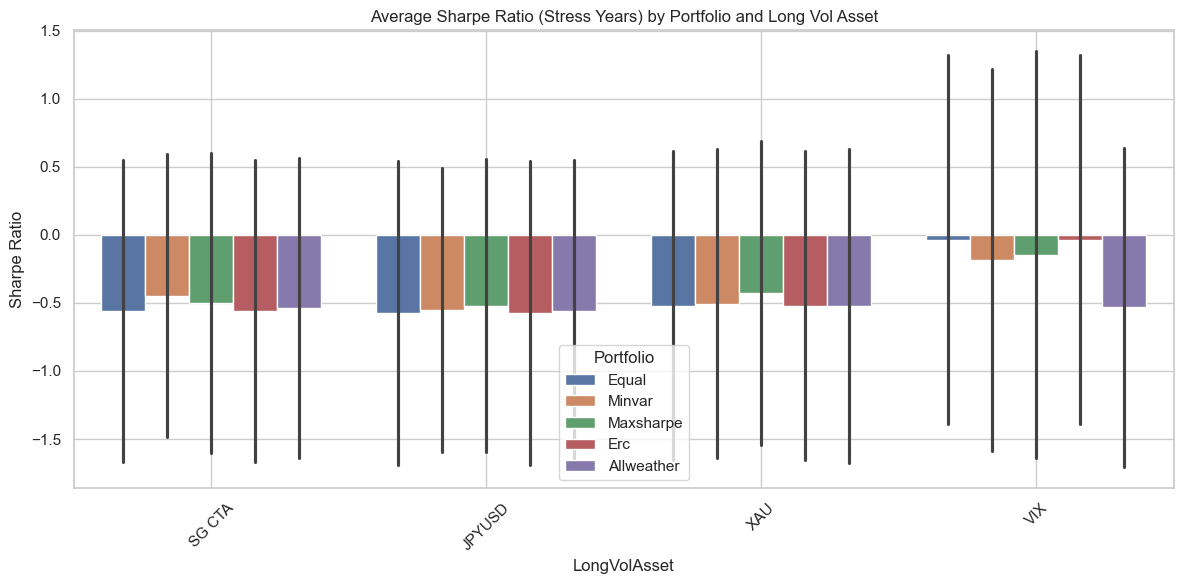

In [159]:
file_path = "Rolling_Stress_Metrics_By_LongVol.xlsx"
excel_file = pd.ExcelFile(file_path)
sheets = [s for s in excel_file.sheet_names if s.endswith("_Metrics")]

combined_data = []

for sheet in sheets:
    df = pd.read_excel(file_path, sheet_name=sheet)
    df.columns = df.columns.str.strip()  # clean up accidental spaces
    if all(col in df.columns for col in ["Portfolio", "Eval Year", "Sharpe"]):
        df["LongVolAsset"] = sheet.replace("_Metrics", "")
        combined_data.append(df[["Portfolio", "Eval Year", "Sharpe", "LongVolAsset"]])
    else:
        print(f"Skipping sheet {sheet}: required columns missing -> {df.columns.tolist()}")

df_all = pd.concat(combined_data, ignore_index=True)

# === Save Combined Table ===
df_all.to_excel("Rolling_Sharpe_Ratios_Detailed_Clean.xlsx", index=False)

# === Create Pivot Table ===
pivot_table = df_all.pivot_table(index="LongVolAsset", columns="Portfolio", values="Sharpe", aggfunc="mean").round(3)
pivot_table.to_excel("Rolling_Sharpe_Pivot_Table.xlsx")

# === Plot: Average Sharpe by LongVolAsset and Portfolio ===
plt.figure(figsize=(12, 6))
sns.barplot(data=df_all, x="LongVolAsset", y="Sharpe", hue="Portfolio", errorbar="sd")
plt.title("Average Sharpe Ratio (Stress Years) by Portfolio and Long Vol Asset")
plt.ylabel("Sharpe Ratio")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/

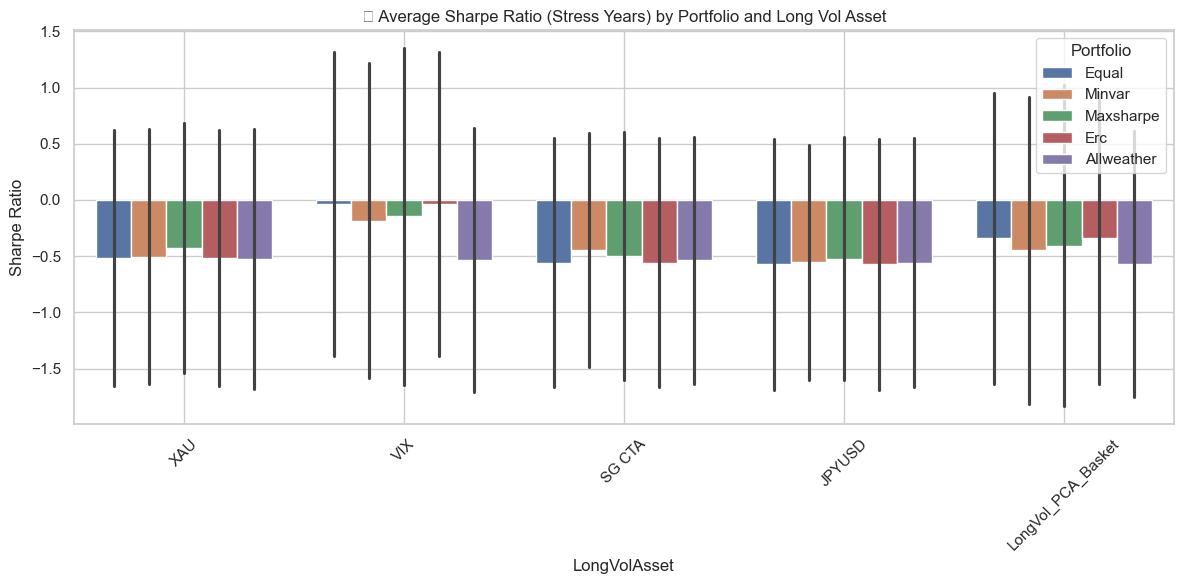

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# === Load the Data ===
file_path = "data indices.xlsx"
all_returns_df = pd.read_excel(file_path, sheet_name="all returns", index_col=0)
all_returns_df.index = pd.to_datetime(all_returns_df.index)
all_returns_df = all_returns_df.sort_index()

# === Configuration ===
traditional_assets = [
    'SPXT return', 'RTY return', 'MXWOU return', 'LUATTRUU return', 'LUACTRUU return',
    'LF98TRUU return', 'SPGSCITR return', 'ENGL return', 'SPLPEQTR return', 'MXWD0INHF return'
]
long_vol_assets = ['XAU return', 'VIX return', 'SG CTA return', 'JPYUSD return']
objectives = ['equal', 'minvar', 'maxsharpe', 'erc', 'allweather']
evaluation_years = [2008, 2016, 2018, 2020, 2022]
rf_rate = 0.016309042801556418

# === Define Portfolio Optimizer (Simplified: Equal weights, MinVar, MaxSharpe, ERC, AllWeather) ===
from scipy.optimize import minimize

def bootstrap_portfolio(returns, objective, rf_rate=0.0, n_samples=100):
    n_assets = returns.shape[1]
    bounds = tuple((0.05, 0.3) for _ in range(n_assets))
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

    def portfolio_perf(w):
        ret = np.mean(returns @ w) * 12
        vol = np.std(returns @ w) * np.sqrt(12)
        return ret, vol

    def min_var(w): return portfolio_perf(w)[1]
    def neg_sharpe(w): ret, vol = portfolio_perf(w); return -(ret - rf_rate) / vol
    def equal_risk(w):
        port_vol = np.std(returns @ w)
        mrc = returns.cov() @ w
        rc = w * mrc
        return np.sum((rc - rc.mean())**2)

    if objective == 'equal':
        return None, np.array([1/n_assets] * n_assets), None
    if objective == 'allweather':
        vol = returns.std()
        inv_vol = 1 / vol
        weights = inv_vol / inv_vol.sum()
        return None, weights.values, None

    obj_func = {'minvar': min_var, 'maxsharpe': neg_sharpe, 'erc': equal_risk}[objective]

    boot_weights = []
    for _ in range(n_samples):
        sample = returns.sample(n=len(returns), replace=True)
        res = minimize(obj_func, [1/n_assets]*n_assets, bounds=bounds, constraints=constraints)
        if res.success:
            boot_weights.append(res.x)
    boot_weights = np.array(boot_weights)
    return boot_weights, boot_weights.mean(axis=0), boot_weights.std(axis=0)

# === Compute PCA Basket ===
lv_data = all_returns_df[long_vol_assets].dropna()
pca = PCA(n_components=1)
pc1 = pca.fit_transform(lv_data)
pc1_series = pd.Series(pc1.flatten(), index=lv_data.index)
all_returns_df['LongVol_PCA_Basket return'] = pc1_series

# Add PCA to list of long vol assets
long_vol_assets += ['LongVol_PCA_Basket return']

# === Rolling Evaluation Loop ===
results = []

for lv in long_vol_assets:
    lv_name = lv.replace(" return", "")
    extended_assets = traditional_assets + [lv]
    df_lv = all_returns_df[extended_assets].dropna()
    df_lv.columns = [col.replace(" return", "") for col in df_lv.columns]

    for eval_year in evaluation_years:
        in_start, in_end = f"{eval_year - 2}-01", f"{eval_year - 1}-12"
        out_start, out_end = f"{eval_year}-01", f"{eval_year}-12"
        insample = df_lv.loc[in_start:in_end]
        oos = df_lv.loc[out_start:out_end]

        if len(insample) < 24 or len(oos) < 12:
            continue

        for obj in objectives:
            try:
                _, avg_w, _ = bootstrap_portfolio(insample, obj, rf_rate=rf_rate, n_samples=100)
                port_ret = oos @ avg_w
                ann_ret = port_ret.mean() * 12
                ann_vol = port_ret.std() * np.sqrt(12)
                sharpe = (ann_ret - rf_rate) / ann_vol

                results.append({
                    "LongVolAsset": lv_name,
                    "Portfolio": obj.capitalize(),
                    "Eval Year": eval_year,
                    "Sharpe": round(sharpe, 4)
                })
            except:
                continue

# Create DataFrame
df_results = pd.DataFrame(results)

# Save to Excel
excel_path = "Rolling_Stress_Sharpe_Results_AllLongVol.xlsx"
df_results.to_excel(excel_path, index=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x="LongVolAsset", y="Sharpe", hue="Portfolio", errorbar="sd")
plt.title("📉 Average Sharpe Ratio (Stress Years) by Portfolio and Long Vol Asset")
plt.ylabel("Sharpe Ratio")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [163]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Load the existing long vol returns data
file_path = "data indices.xlsx"
all_returns_df = pd.read_excel(file_path, sheet_name="all returns", index_col=0)
all_returns_df.index = pd.to_datetime(all_returns_df.index)
all_returns_df = all_returns_df.sort_index()

# Define long volatility assets
long_vol_assets = ['SG CTA return', 'JPYUSD return', 'XAU return', 'VIX return']

# Step 1: Equal-Weighted Basket
equal_weights = np.repeat(1 / len(long_vol_assets), len(long_vol_assets))
equal_weighted_basket = all_returns_df[long_vol_assets] @ equal_weights
all_returns_df["LongVol_Equal_Basket"] = equal_weighted_basket

# Step 2: PCA Basket (first principal component)
standardized_returns = (all_returns_df[long_vol_assets] - all_returns_df[long_vol_assets].mean()) / all_returns_df[long_vol_assets].std()
pca = PCA(n_components=1)
pca.fit(standardized_returns.dropna())
pca_weights = pca.components_[0]
pca_weights_normalized = pca_weights / np.sum(np.abs(pca_weights))  # Normalize for interpretation
pca_basket = standardized_returns @ pca_weights_normalized
all_returns_df["LongVol_PCA_Basket"] = pca_basket

# Output PCA weights and first few rows of new columns
equal_basket_preview = all_returns_df[["LongVol_Equal_Basket", "LongVol_PCA_Basket"]].dropna().head()
pca_weight_series = pd.Series(pca_weights_normalized, index=long_vol_assets).round(4)

equal_basket_preview, pca_weight_series


(            LongVol_Equal_Basket  LongVol_PCA_Basket
 Date                                                
 2000-01-31             -0.006239            0.562890
 2000-02-29             -0.016704            0.110009
 2000-03-31              0.010228           -0.068590
 2000-04-28              0.000633            0.869437
 2000-05-31             -0.024088            0.118035,
 SG CTA return   -0.1584
 JPYUSD return   -0.3113
 XAU return      -0.4664
 VIX return      -0.0640
 dtype: float64)

In [165]:
long_vol_columns = ['XAU return', 'VIX return', 'SG CTA return', 'JPYUSD return']

equal_basket_returns = long_vol_returns.mean(axis=1)
returns_df["LongVol_Equal_Basket"] = equal_basket_returns

# Create PCA Weighted Basket
pca = PCA(n_components=1)
pca.fit(long_vol_returns)
pc1_loadings = np.abs(pca.components_[0])
pca_weights = pc1_loadings / np.sum(pc1_loadings)
pca_basket_returns = long_vol_returns @ pca_weights
returns_df["LongVol_PCA_Basket"] = pca_basket_returns

# Prepare preview DataFrame
weights_df = pd.DataFrame({
    "Asset": long_vol_columns,
    "PCA Weight": pca_weights.round(3)
})

sample_returns = returns_df[["LongVol_Equal_Basket", "LongVol_PCA_Basket"]].head(10)


In [166]:
print(sample_returns)

            LongVol_Equal_Basket  LongVol_PCA_Basket
2005-01-31             -0.027026           -0.034958
2005-02-28             -0.006364           -0.056158
2005-03-31              0.030868            0.156109
2005-04-30                   NaN                 NaN
2005-05-31             -0.047988           -0.129185
2005-06-30             -0.013068           -0.091618
2005-07-31                   NaN                 NaN
2005-08-31              0.029780            0.087066
2005-09-30              0.003824           -0.052453
2005-10-31              0.063246            0.277584


In [170]:
long_vol_columns = ['XAU', 'VIX', 'SG CTA', 'JPYUSD']

returns_df[long_vol_columns].isna().sum()
returns_df[long_vol_columns].dropna().head(1)


XAU       VIX    SG CTA    JPYUSD
2005-01-31  0.050691 -0.002025 -0.002024  0.052376